## Carga y limpieza de datos

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from prophet import Prophet
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_percentage_error


**Estilo gráfico**

In [10]:
sns.set(style="whitegrid", rc={
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "0.15",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "font.size": 12})

palette_corp = ["#2A4D69", "#4B86B4", "#ADCBE3", "#63ACE5", "#D7263D"]

Se definió un estilo visual corporativo consistente para garantizar claridad en todas las visualizaciones del EDA.

**Carga de archivos CSV**

In [11]:
ventas = pd.read_csv('../data/ventas.csv')
productos = pd.read_csv('../data/productos.csv')
clientes = pd.read_csv('../data/clientes.csv')
metodos_pago = pd.read_csv('../data/metodos_pago.csv')
categorias = pd.read_csv('../data/categorias.csv')

Se cargaron las 5 fuentes principales: ventas, clientes, productos, categorías y métodos de pago.

**Uniformar nombres y encoding**

In [12]:
for df in [ventas, productos, clientes, metodos_pago, categorias]:
    df.columns = df.columns.str.strip()

# Correcciones de encoding frecuentes
metodos_pago.rename(columns={"MÃ©todo": "Método"}, inplace=True)

**Conversión de tipos y manejo de nulos**

In [13]:
#Conversión de tipos y fechas
ventas["Fecha_Ventas"] = pd.to_datetime(ventas["Fecha_Ventas"], errors="coerce", dayfirst=True)
clientes["Fecha_Registro"] = pd.to_datetime(clientes["Fecha_Registro"], errors="coerce", dayfirst=True)

productos["Precio_Unitario"] = (
    productos["Precio_Unitario"].astype(str).str.replace(",", ".", regex=False)
).astype(float)

ventas["Cantidad"] = pd.to_numeric(ventas["Cantidad"], errors="coerce")

#nulos
ventas = ventas.dropna(subset=["Fecha_Ventas"])
productos["Precio_Unitario"].fillna(productos["Precio_Unitario"].median(), inplace=True)
productos["Stock"].fillna(0, inplace=True)

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\4288490507.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  productos["Precio_Unitario"].fillna(productos["Precio_Unitario"].median(), inplace=True)
C:\Users\erida\AppData\Local\Temp\ipykernel_32484\4288490507.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

**Uniones**

In [14]:
# Join productos
productos_full = productos.merge(categorias, on="Categoría", how="left")

# Merge ventas with productos_full
ventas_full = ventas.merge(productos_full, on="ID_Producto", how="left")

# Join clientes
ventas_full = ventas_full.merge(clientes, on="ID_Cliente", how="left")

# Join método pago
mp = metodos_pago.rename(columns={"ID_Metodo":"Método_Pago"})
ventas_full = ventas_full.merge(mp, on="Método_Pago", how="left")

**Generación de columnas de fecha**

In [15]:
#fechas en ventas
ventas_full["Año"] = ventas_full["Fecha_Ventas"].dt.year
ventas_full["Mes"] = ventas_full["Fecha_Ventas"].dt.month
ventas_full["Dia"] = ventas_full["Fecha_Ventas"].dt.day
ventas_full["Dia_Semana"] = ventas_full["Fecha_Ventas"].dt.dayofweek

map_dias = {0:"Lun",1:"Mar",2:"Mié",3:"Jue",4:"Vie",5:"Sáb",6:"Dom"}
ventas_full["Dia_Semana"] = ventas_full["Dia_Semana"].map(map_dias)

**Cálculo del ingreso**

In [16]:
ventas_full["Ingreso"] = ventas_full["Cantidad"] * ventas_full["Precio_Unitario"]

print("Shape final:", ventas_full.shape)
ventas_full.head()

Shape final: (3029, 25)


,ID_Venta,Fecha_Ventas,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre_producto,Categoría,Precio_Unitario,...,Email,Fecha_Registro,Región,Método,Descripción_y,Año,Mes,Dia,Dia_Semana,Ingreso
0,919,2024-01-31,10,25,5,1,Completa,Pizza congelada,Congelados,15.45,...,ssexty9@domainmarket.com,2023-11-23,Buenos Aires,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,77.25
1,947,2024-01-31,106,5,1,4,Completa,Manteca,Lácteos,5.65,...,bcondon2x@paypal.com,2023-06-23,NEA,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Pizza congelada,Congelados,15.45,...,cbrun6i@theglobeandmail.com,2023-12-11,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,31,Mié,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Medialunas,Panadería,3.51,...,froskam35@desdev.cn,2023-04-11,Centro,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Yogur,Lácteos,5.21,...,ccorish3n@virginia.edu,2023-12-14,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,26.05


In [17]:
ventas_full

,ID_Venta,Fecha_Ventas,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre_producto,Categoría,Precio_Unitario,...,Email,Fecha_Registro,Región,Método,Descripción_y,Año,Mes,Dia,Dia_Semana,Ingreso
0,919,2024-01-31,10,25,5,1,Completa,Pizza congelada,Congelados,15.45,...,ssexty9@domainmarket.com,2023-11-23,Buenos Aires,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,77.25
1,947,2024-01-31,106,5,1,4,Completa,Manteca,Lácteos,5.65,...,bcondon2x@paypal.com,2023-06-23,NEA,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Pizza congelada,Congelados,15.45,...,cbrun6i@theglobeandmail.com,2023-12-11,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,31,Mié,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Medialunas,Panadería,3.51,...,froskam35@desdev.cn,2023-04-11,Centro,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Yogur,Lácteos,5.21,...,ccorish3n@virginia.edu,2023-12-14,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,26.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,2024-12-30,44,12,6,4,Completa,Pan francés,Panadería,8.12,...,crunge17@sfgate.com,2023-09-17,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,12,30,Lun,48.72
3025,1390,2024-12-30,26,31,3,4,Completa,Galletitas de agua,Galletitas y Snacks,5.24,...,bsorop@senate.gov,2023-07-05,Centro,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,12,30,Lun,15.72
3026,1519,2024-12-30,246,11,3,3,Completa,Salchicha,Carnicería,11.23,...,azottoli6t@prweb.com,2023-09-28,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,12,30,Lun,33.69
3027,2147,2024-12-30,231,22,2,1,Pendiente,Cebolla,Frutas y Verduras,4.21,...,rchattelaine6e@list-manage.com,2023-12-13,Patagonia,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,12,30,Lun,8.42


Se creó la métrica central del análisis: Ingreso, multiplicando precio unitario por cantidad vendida.

## EDA

El objetivo de esta sección es entender la estructura del negocio, detectar patrones
de ventas, identificar estacionalidad, revisar distribuciones de productos y métodos
de pago, y validar la calidad del dataset.

El EDA permite responder preguntas clave como:

- ¿Cuáles son los días y meses con mayor volumen de ventas?
- ¿Qué categorías dominan el ingreso?
- ¿Existen patrones semanales de comportamiento del consumidor?
- ¿Cómo se distribuyen métodos de pago y ticket promedio?
- ¿Qué productos tienen mayor presencia en el portafolio?

Estas observaciones sirven como base para los modelos posteriores de RFM,
segmentación, elasticidad de precios y forecasting.

### Bloque 1 - Mapa General del Negocio

#### KPIs globales del supermercado

In [18]:
# Ingreso total del año
kpi_ingreso_total = ventas_full["Ingreso"].sum()

# Número total de tickets (ventas)
kpi_ventas = ventas_full["ID_Venta"].nunique()

# Clientes únicos
kpi_clientes = ventas_full["ID_Cliente"].nunique()

# Productos únicos
kpi_productos = ventas_full["ID_Producto"].nunique()

# Ticket promedio (por ticket, no por producto)
ticket_promedio = (
    ventas_full
    .groupby("ID_Venta")["Ingreso"]
    .sum()
    .mean()
)

print("===== KPIs Globales =====")
print(f"Ingreso Total: ${kpi_ingreso_total:,.2f}")
print(f"Número de Ventas (tickets): {kpi_ventas:,}")
print(f"Clientes Únicos: {kpi_clientes:,}")
print(f"Productos Únicos: {kpi_productos:,}")
print(f"Ticket Promedio: ${ticket_promedio:,.2f}")

===== KPIs Globales =====
Ingreso Total: $103,947.36
Número de Ventas (tickets): 3,000
Clientes Únicos: 326
Productos Únicos: 38
Ticket Promedio: $34.65


#### KPIs por Region

In [19]:
kpi_region = (
    ventas_full
    .groupby("Región")
    .agg(
        Ingreso_Total=("Ingreso", "sum"),
        Ventas=("ID_Venta", "nunique"),
        Clientes_Unicos=("ID_Cliente", "nunique")
    )
    .reset_index()
)

# Ticket promedio por región
kpi_region["Ticket_Promedio"] = (
    kpi_region["Ingreso_Total"] / kpi_region["Ventas"]
)

# Orden de mayor a menor ingreso
kpi_region = kpi_region.sort_values("Ingreso_Total", ascending=False)

kpi_region

,Región,Ingreso_Total,Ventas,Clientes_Unicos,Ticket_Promedio
0,Buenos Aires,37144.80,1032,111,35.993023
1,Centro,20363.58,601,63,33.882829
5,Patagonia,18553.53,553,64,33.550687
2,Cuyo,14177.49,403,44,35.179876
3,NEA,11251.32,348,37,32.331379
4,NOA,2456.64,63,7,38.994286


#### Ingresos por región

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3636716004.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3636716004.py:6: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


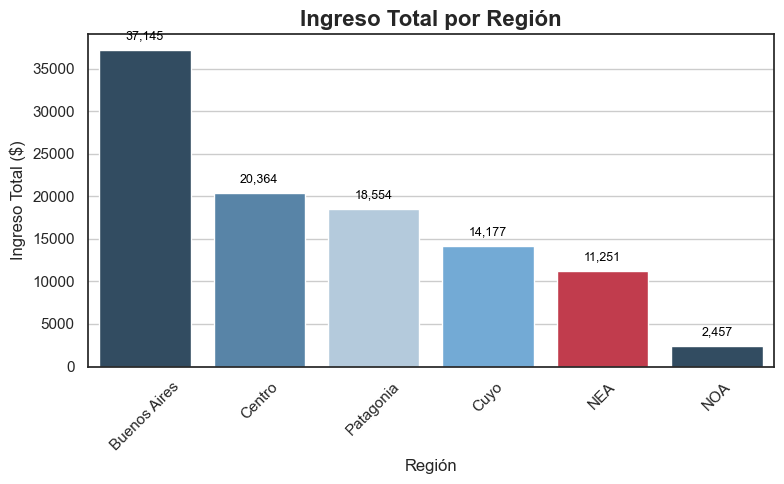

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

ax = sns.barplot(
    data=kpi_region,
    x="Región",
    y="Ingreso_Total",
    palette=palette_corp
)

for p in ax.patches:

    value = f'{p.get_height():,.0f}'
    
    ax.annotate(value, 
                (p.get_x() + p.get_width() / 2., p.get_height()), # Posición (x, y)
                ha = 'center',           # Alineación horizontal: Centrada
                va = 'center',           # Alineación vertical: Centrada
                xytext = (0, 10),        # Desplazamiento de 10 puntos hacia arriba
                textcoords = 'offset points',
                fontsize=9,
                color='black')

plt.title("Ingreso Total por Región")
plt.xlabel("Región")
plt.ylabel("Ingreso Total ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esta visualización nos muestra que la región que tiene el mayor volumen de ingresos totales es Buenos Aires con más de 35000, mientras que la de menor ingresos es NOA con alrededor de 3000

#### Ticket promedio por región

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3542721396.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3542721396.py:8: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


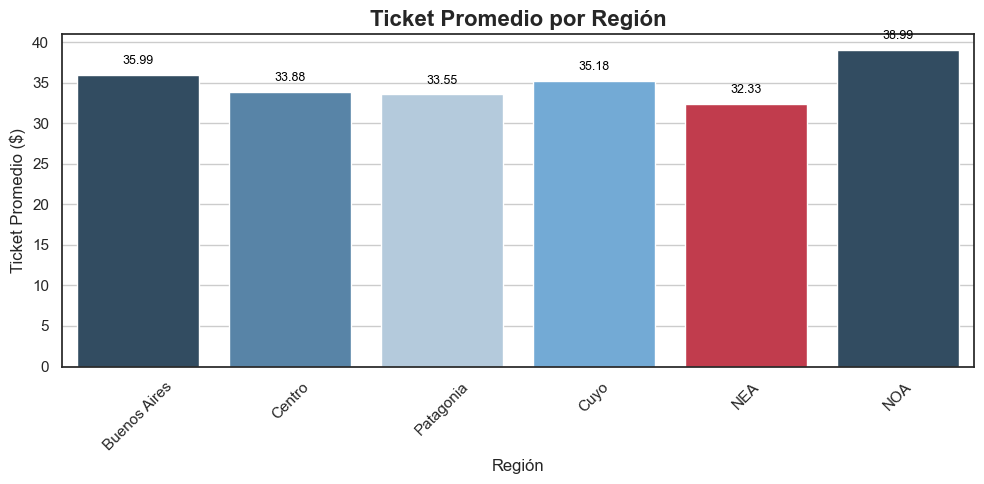

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Asegúrate de que kpi_region y palette_corp estén definidos antes de este bloque

plt.figure(figsize=(10,5))

# 1. Crear el gráfico y guardar el objeto Axes
ax = sns.barplot(
    data=kpi_region,
    x="Región",
    y="Ticket_Promedio",
    palette=palette_corp
)

# 2. Iterar sobre las barras (patches) y añadir la etiqueta
for p in ax.patches:
    # Obtener el valor de la barra (Ticket_Promedio)
    # Formatear el valor con separadores de miles y dos decimales (ej. 1,234.56)
    value = f'{p.get_height():,.2f}'
    
    # Añadir la etiqueta en la parte superior central de la barra
    ax.annotate(value, 
                (p.get_x() + p.get_width() / 2., p.get_height()), # Posición (x, y)
                ha = 'center',           # Alineación horizontal: Centrada
                va = 'center',           # Alineación vertical: Centrada
                xytext = (0, 10),        # Desplazamiento de 10 puntos hacia arriba
                textcoords = 'offset points',
                fontsize=9,
                color='black')

# 3. Configurar el resto del gráfico
plt.title("Ticket Promedio por Región")
plt.xlabel("Región")
plt.ylabel("Ticket Promedio ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esta gráfica muestra que NOA es la región con los tickets con mayor valor promedio (con un promedio de casi \$39), mientras que NEA es la región con los tickets de menor valor promedio (con un promedio de casi **\$32.5**).

A pesar de que NOA es la región con menos ingresos totales por región, se mantiene en primer lugar del ticket promedio por región. Esto muestra que el valor promedio de la transacción no tiene una correlación directa con el ingreso total, ya que el ingreso total depende del volumen de ventas, no solo del valor promedio del ticket.

#### Ingreso total vs Ticket promedio por región

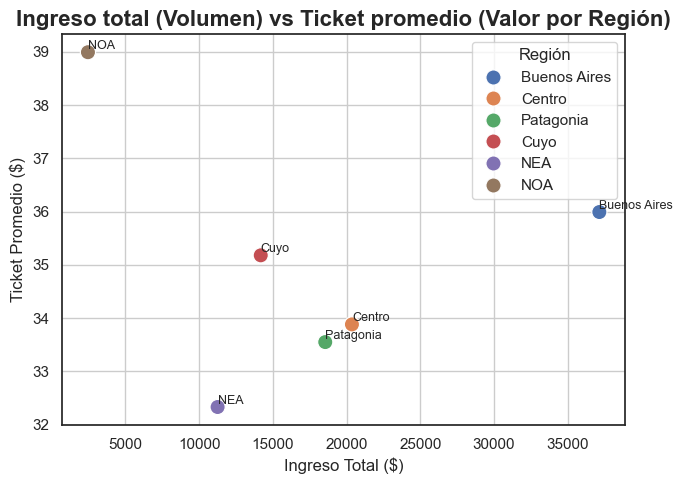

In [22]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=kpi_region,
    x="Ingreso_Total",
    y="Ticket_Promedio",
    hue="Región",
    s=120
)

for _, row in kpi_region.iterrows():
    plt.text(
        row["Ingreso_Total"],
        row["Ticket_Promedio"],
        row["Región"],
        fontsize=9,
        ha="left",
        va="bottom"
    )

plt.title("Ingreso total (Volumen) vs Ticket promedio (Valor por Región)")
plt.xlabel("Ingreso Total ($)")
plt.ylabel("Ticket Promedio ($)")
plt.tight_layout()
plt.show()


Esto nos indica que aunque exista una concentración bastante grande de clientes en la región de Buenos Aires, el lugar en donde se carga el mayor valor por transacción es la región de NOA. 

### Bloque 2 - Estacionalidad: Cuándo compra cada región

### Tabla de ingresos por día de la semana y región

In [23]:
# Ingreso total por día de la semana y región
ingreso_semana_region = (
    ventas_full
    .groupby(["Región", "Dia_Semana"], as_index=False)["Ingreso"]
    .sum()
)

orden_dias = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
ingreso_semana_region["Dia_Semana"] = pd.Categorical(
    ingreso_semana_region["Dia_Semana"],
    categories=orden_dias,
    ordered=True
)

ingreso_semana_region = ingreso_semana_region.sort_values(
    ["Región", "Dia_Semana"]
)

ingreso_semana_region

,Región,Dia_Semana,Ingreso
2,Buenos Aires,Lun,5691.66
3,Buenos Aires,Mar,5270.02
4,Buenos Aires,Mié,5315.56
1,Buenos Aires,Jue,5252.67
6,Buenos Aires,Vie,5981.47
5,Buenos Aires,Sáb,4452.22
0,Buenos Aires,Dom,5181.20
9,Centro,Lun,2582.00
10,Centro,Mar,2883.60
11,Centro,Mié,2693.27


### Heatmap del Ingreso por día de la semana y región

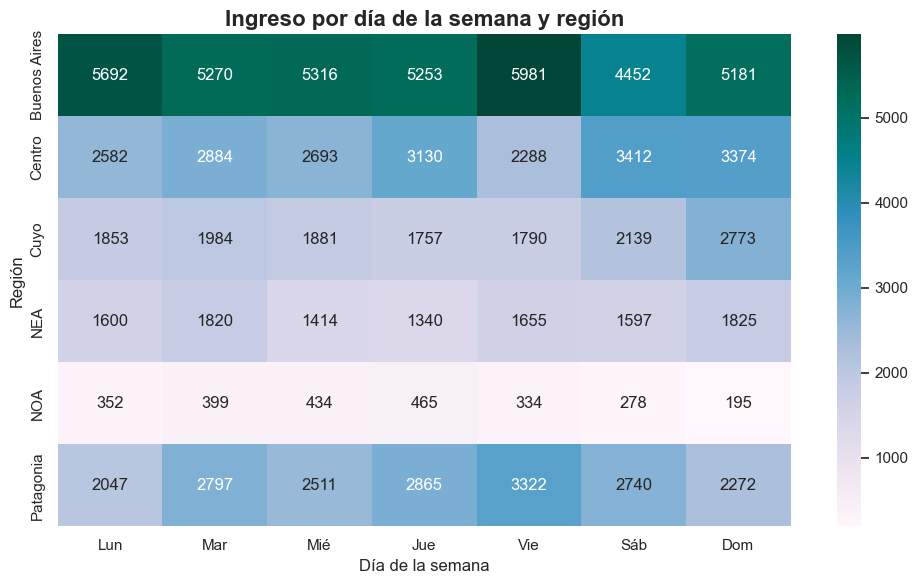

In [24]:
# Heatmap
tabla_semana_region = ingreso_semana_region.pivot(
    index="Región",
    columns="Dia_Semana",
    values="Ingreso"
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    tabla_semana_region,
    annot=True,
    fmt=".0f",
    cmap="PuBuGn"
)

plt.title("Ingreso por día de la semana y región")
plt.xlabel("Día de la semana")
plt.ylabel("Región")
plt.tight_layout()
plt.show()

#### Etiquetas de mes

In [25]:
map_meses = {
    1: "Ene", 2: "Feb", 3: "Mar", 4: "Abr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Ago",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dic"
}

ventas_full["Mes_Label"] = ventas_full["Mes"].map(map_meses)
ventas_full["Mes_Label"] = pd.Categorical(
    ventas_full["Mes_Label"],
    categories=["Ene","Feb","Mar","Abr","May","Jun",
                "Jul","Ago","Sep","Oct","Nov","Dic"],
    ordered=True
)

#### Estacionalidad mensual por región 

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3973052467.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Año", "Mes", "Mes_Label", "Región"], as_index=False)["Ingreso"]


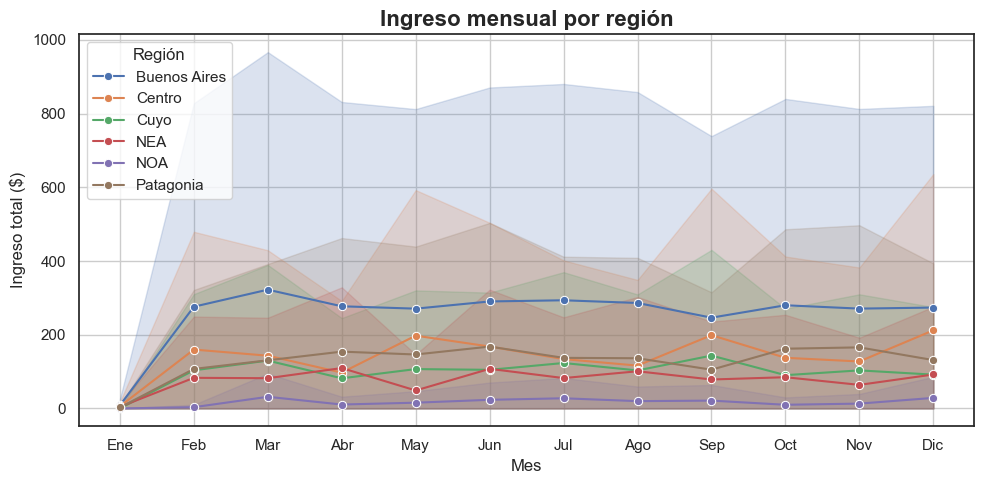

In [26]:
# Ingreso mensual por región 
ingreso_mensual_region = (
    ventas_full
    .groupby(["Año", "Mes", "Mes_Label", "Región"], as_index=False)["Ingreso"]
    .sum()
    .sort_values(["Año", "Mes"])
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=ingreso_mensual_region,
    x="Mes_Label",
    y="Ingreso",
    hue="Región",
    marker="o"
)
plt.title("Ingreso mensual por región")
plt.xlabel("Mes")
plt.ylabel("Ingreso total ($)")
plt.legend(title="Región")
plt.tight_layout()
plt.show()

La gráfica muestra que la región de Buenos Aires es el principal motor de ingresos y la fuente de la mayor parte de la volatilidad del negocio.

Asimismo, se aprecia una fuerte estacionalidad de inicio de año, ya que se muestra una alta ciclicidad con un pico masivo en Febrero-Marzo, seguido de una caída en la mitad del año y un repunte menor hacia Diciembre.

Heatmap mensual por región

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\2691522164.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Región", "Mes_Label"], as_index=False)["Ingreso"]


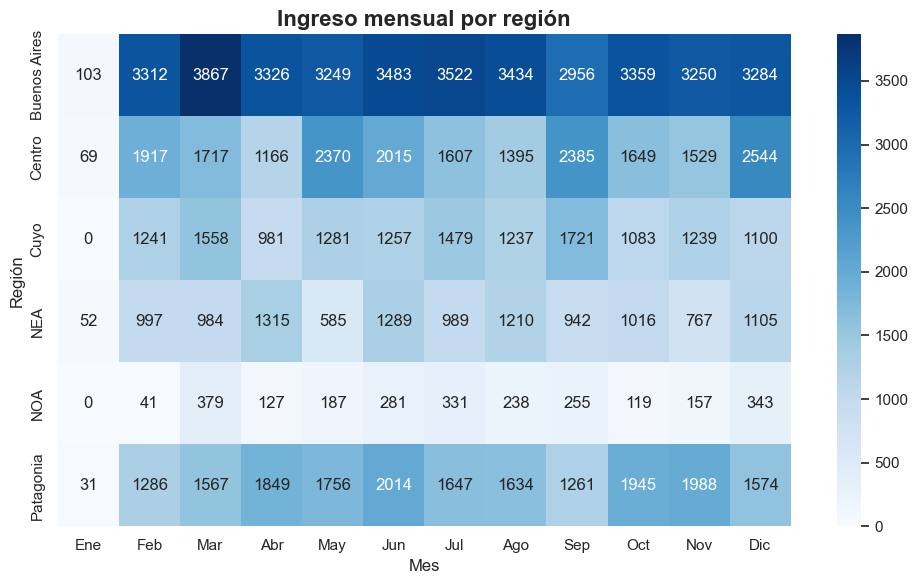

In [27]:
# Agrupar por Región y Mes_Label (independiente del año)
tabla_mes_region = (
    ingreso_mensual_region
    .groupby(["Región", "Mes_Label"], as_index=False)["Ingreso"]
    .sum()
    .pivot(index="Región", columns="Mes_Label", values="Ingreso")
)

plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_mes_region,
    annot=True,
    fmt=".0f",
    cmap="Blues"
)
plt.title("Ingreso mensual por región")
plt.xlabel("Mes")
plt.ylabel("Región")
plt.tight_layout()
plt.show()

Ingreso total por categoría y región

In [28]:
ingreso_cat_region = (
    ventas_full
    .groupby(["Región", "Categoría"], as_index=False)["Ingreso"]
    .sum()
)

tabla_cat_region = (
    ingreso_cat_region
    .pivot(index="Categoría", columns="Región", values="Ingreso")
    .fillna(0)
)

tabla_cat_region

Región,Buenos Aires,Centro,Cuyo,NEA,NOA,Patagonia
Categoría,,,,,,
Bebidas,4093.72,2079.87,1764.59,1206.22,415.32,2181.90
Carnicería,11319.11,5409.28,3348.01,2553.09,660.15,4896.54
Congelados,4953.21,3060.45,2258.95,1527.57,388.71,2845.52
Conservas,1499.34,921.27,763.40,787.97,72.91,889.07
Frutas y Verduras,2786.90,1497.64,1184.13,1013.51,257.42,1165.78
Galletitas y Snacks,2634.36,1535.25,732.24,761.16,52.66,1449.51
Lácteos,5815.37,3937.49,1857.41,1852.36,337.12,2380.18
Panadería,4042.79,1922.33,2268.76,1549.44,272.35,2745.03


Heatmap de ingreso por categoría y región

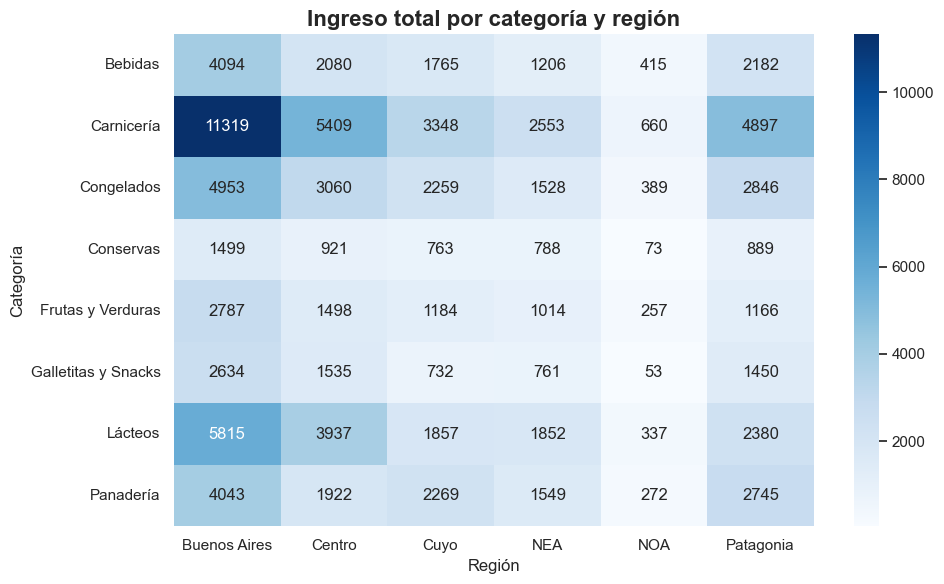

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    tabla_cat_region,
    annot=True,
    fmt=".0f",
    cmap="Blues"
)
plt.title("Ingreso total por categoría y región")
plt.xlabel("Región")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

In [30]:
ventas_full.head()

,ID_Venta,Fecha_Ventas,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre_producto,Categoría,Precio_Unitario,...,Fecha_Registro,Región,Método,Descripción_y,Año,Mes,Dia,Dia_Semana,Ingreso,Mes_Label
0,919,2024-01-31,10,25,5,1,Completa,Pizza congelada,Congelados,15.45,...,2023-11-23,Buenos Aires,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,77.25,Ene
1,947,2024-01-31,106,5,1,4,Completa,Manteca,Lácteos,5.65,...,2023-06-23,NEA,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,5.65,Ene
2,1317,2024-01-31,235,25,3,3,Completa,Pizza congelada,Congelados,15.45,...,2023-12-11,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,31,Mié,46.35,Ene
3,1607,2024-01-31,114,15,5,1,Completa,Medialunas,Panadería,3.51,...,2023-04-11,Centro,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,17.55,Ene
4,2038,2024-01-31,132,2,5,4,Completa,Yogur,Lácteos,5.21,...,2023-12-14,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,26.05,Ene


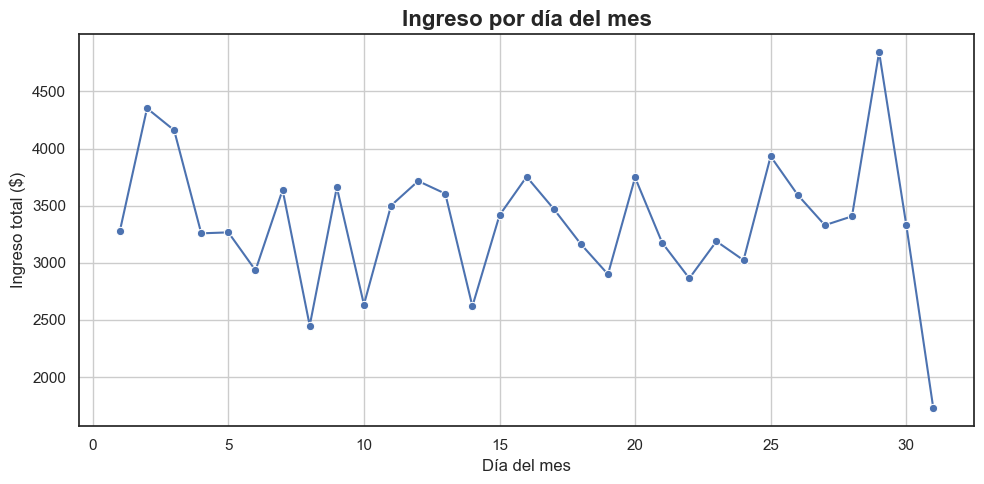

In [31]:
# Ingreso diario
ingreso_dia = (
    ventas_full
    .groupby("Dia", as_index=False)["Ingreso"]
    .sum()
    .sort_values("Dia")
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=ingreso_dia,
    x="Dia",
    y="Ingreso",
    marker="o"
)
plt.title("Ingreso por día del mes")
plt.xlabel("Día del mes")
plt.ylabel("Ingreso total ($)")
plt.tight_layout()
plt.show()

Participación porcentual del ingreso por categoría y región

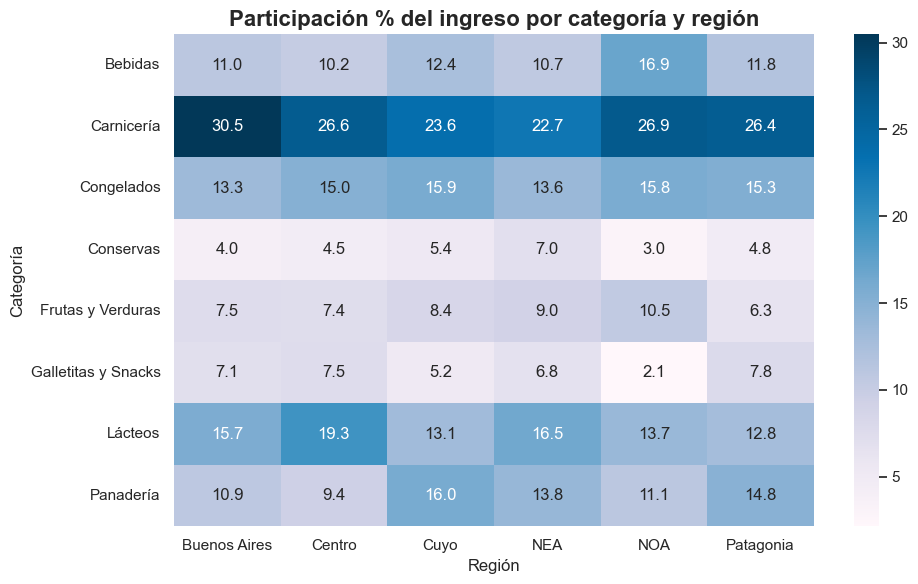

In [32]:
tabla_cat_region_pct = tabla_cat_region.div(tabla_cat_region.sum(axis=0), axis=1) * 100

tabla_cat_region_pct.round(1)

plt.figure(figsize=(10, 6))
sns.heatmap(
    tabla_cat_region_pct,
    annot=True,
    fmt=".1f",
    cmap="PuBu"
)
plt.title("Participación % del ingreso por categoría y región")
plt.xlabel("Región")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

Top 3 categorías por región

In [33]:
top3_cat_region = (
    ingreso_cat_region
    .sort_values(["Región", "Ingreso"], ascending=[True, False])
    .groupby("Región")
    .head(3)
)


for region in top3_cat_region["Región"].unique():
    sub = top3_cat_region[top3_cat_region["Región"] == region]
    print(f"\n{region}:")
    for _, fila in sub.iterrows():
        print(f"  - {fila['Categoría']}: ${fila['Ingreso']:.2f}")


Buenos Aires:
  - Carnicería: $11319.11
  - Lácteos: $5815.37
  - Congelados: $4953.21

Centro:
  - Carnicería: $5409.28
  - Lácteos: $3937.49
  - Congelados: $3060.45

Cuyo:
  - Carnicería: $3348.01
  - Panadería: $2268.76
  - Congelados: $2258.95

NEA:
  - Carnicería: $2553.09
  - Lácteos: $1852.36
  - Panadería: $1549.44

NOA:
  - Carnicería: $660.15
  - Bebidas: $415.32
  - Congelados: $388.71

Patagonia:
  - Carnicería: $4896.54
  - Congelados: $2845.52
  - Panadería: $2745.03


Estacionalidad mensual de bebidas, el más grande de NOA

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\4287839117.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Año", "Mes", "Mes_Label", "Región"], as_index=False)["Ingreso"]


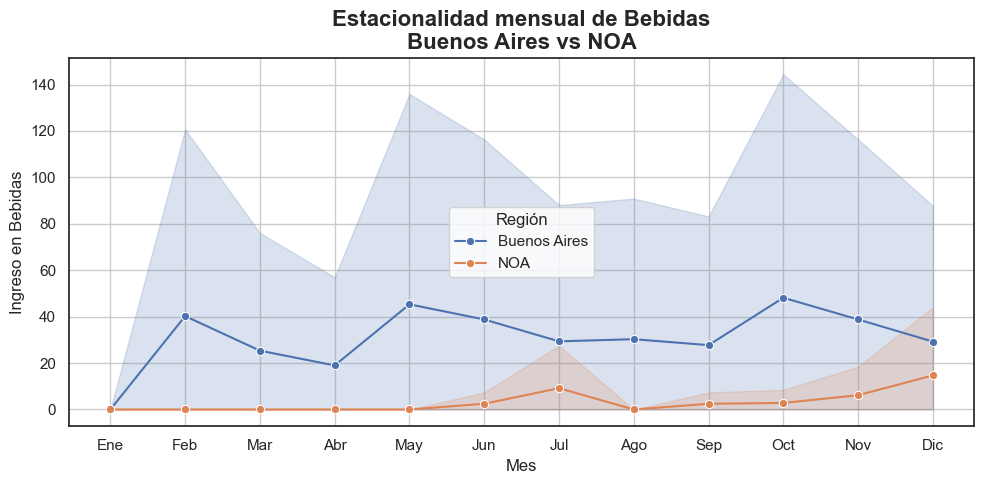

In [34]:
bebidas = ventas_full[ventas_full["Categoría"] == "Bebidas"]

ingreso_bebidas = (
    bebidas
    .groupby(["Año", "Mes", "Mes_Label", "Región"], as_index=False)["Ingreso"]
    .sum()
    .sort_values(["Año", "Mes"])
)

bebidas_focus = ingreso_bebidas[ingreso_bebidas["Región"].isin(["Buenos Aires", "NOA"])]

plt.figure(figsize=(10,5))
sns.lineplot(
    data=bebidas_focus,
    x="Mes_Label",
    y="Ingreso",
    hue="Región",
    marker="o"
)
plt.title("Estacionalidad mensual de Bebidas\nBuenos Aires vs NOA")
plt.xlabel("Mes")
plt.ylabel("Ingreso en Bebidas")
plt.legend(title="Región")
plt.tight_layout()
plt.show()


Si tomamos solo Bebidas y comparamos mes a mes Buenos Aires vs NOA, la historia se separa por completo.

Buenos Aires: bebidas con picos muy marcados

La línea de BA se mueve mucho:

Tiene un pico fuerte en octubre, el más alto del año (ingreso > 500). Suena a inicio de calor, primavera y posible campaña pre-verano.

Hay otro pico raro en mayo, que podría tener que ver con campañas tipo Hot Sale o alguna promo puntual, porque por clima no esperas ese salto tan marcado en bebidas.

Después del verano, en abril cae al mínimo del año (cerca de 200).

Algo curioso: tras el pico de octubre, en vez de seguir subiendo hacia diciembre, cae. No es el típico patrón “clásico” de fin de año en bebidas, así que aquí valdría la pena revisar si hubo temas promocionales, precios o incluso stock.


NOA: pocos datos, pero un patrón propio

La línea del NOA es distinta por dos cosas:

Datos faltantes: no hay registros de febrero a mayo. La serie arranca recién en junio.
Aquí hay que hacer una pausa: no sabemos si no se vendió nada o si hubo un problema de captura. Para cualquier modelo serio, esto es un tema a revisar sí o sí.

Con lo que sí hay:

Hay un salto en julio, que coincide con vacaciones de invierno y con turismo en la zona.

Cierra el año con un repunte en diciembre, probablemente asociado a calor extremo y consumo estacional.

**Bloque 3 - Productos críticos por región**

Ingreso por producto dentro de cada región

In [35]:
prod_region = (
    ventas_full
    .groupby(["Región", "ID_Producto", "Nombre_producto", "Categoría"], as_index=False)["Ingreso"]
    .sum()
)

# Ingreso total de la región
prod_region["Ingreso_Region"] = (
    prod_region
    .groupby("Región")["Ingreso"]
    .transform("sum")
)

# Porcentaje del ingreso regional que aporta cada producto
prod_region["Pct_Region"] = 100 * prod_region["Ingreso"] / prod_region["Ingreso_Region"]

# Ordenar de mayor a menor dentro de cada región
prod_region = prod_region.sort_values(["Región", "Ingreso"], ascending=[True, False])

prod_region

,Región,ID_Producto,Nombre_producto,Categoría,Ingreso,Ingreso_Region,Pct_Region
5,Buenos Aires,6,Asado,Carnicería,3570.00,37144.80,9.611036
3,Buenos Aires,4,Queso rallado,Lácteos,2192.22,37144.80,5.901822
7,Buenos Aires,8,Milanesa,Carnicería,1961.41,37144.80,5.280443
8,Buenos Aires,9,Pollo,Carnicería,1893.12,37144.80,5.096595
24,Buenos Aires,25,Pizza congelada,Congelados,1498.65,37144.80,4.034616
...,...,...,...,...,...,...,...
222,Patagonia,37,Garbanzos,Conservas,178.85,18553.53,0.963968
220,Patagonia,35,Arroz,Conservas,174.25,18553.53,0.939174
205,Patagonia,20,Lechugas,Frutas y Verduras,157.25,18553.53,0.847548
207,Patagonia,22,Cebolla,Frutas y Verduras,122.09,18553.53,0.658042


Top 5 productos más vendidos por región

In [36]:
# Top 5 productos por región más vendidos por ingreso

top5_region = (
    prod_region
    .groupby("Región")
    .head(5)  # ya viene ordenado desc por Ingreso
    [["Región", "Nombre_producto", "Categoría", "Ingreso", "Pct_Region"]]
)

top5_region

,Región,Nombre_producto,Categoría,Ingreso,Pct_Region
5,Buenos Aires,Asado,Carnicería,3570.00,9.611036
3,Buenos Aires,Queso rallado,Lácteos,2192.22,5.901822
7,Buenos Aires,Milanesa,Carnicería,1961.41,5.280443
8,Buenos Aires,Pollo,Carnicería,1893.12,5.096595
24,Buenos Aires,Pizza congelada,Congelados,1498.65,4.034616
41,Centro,Queso rallado,Lácteos,1480.71,7.271364
46,Centro,Pollo,Carnicería,1243.52,6.106588
62,Centro,Pizza congelada,Congelados,1158.75,5.690306
66,Centro,Cerveza,Bebidas,1073.22,5.270291
40,Centro,Queso cremoso,Lácteos,1033.80,5.076710


C:\Users\erida\AppData\Local\Temp\ipykernel_32484\568209838.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\erida\AppData\Local\Temp\ipykernel_32484\568209838.py:3: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


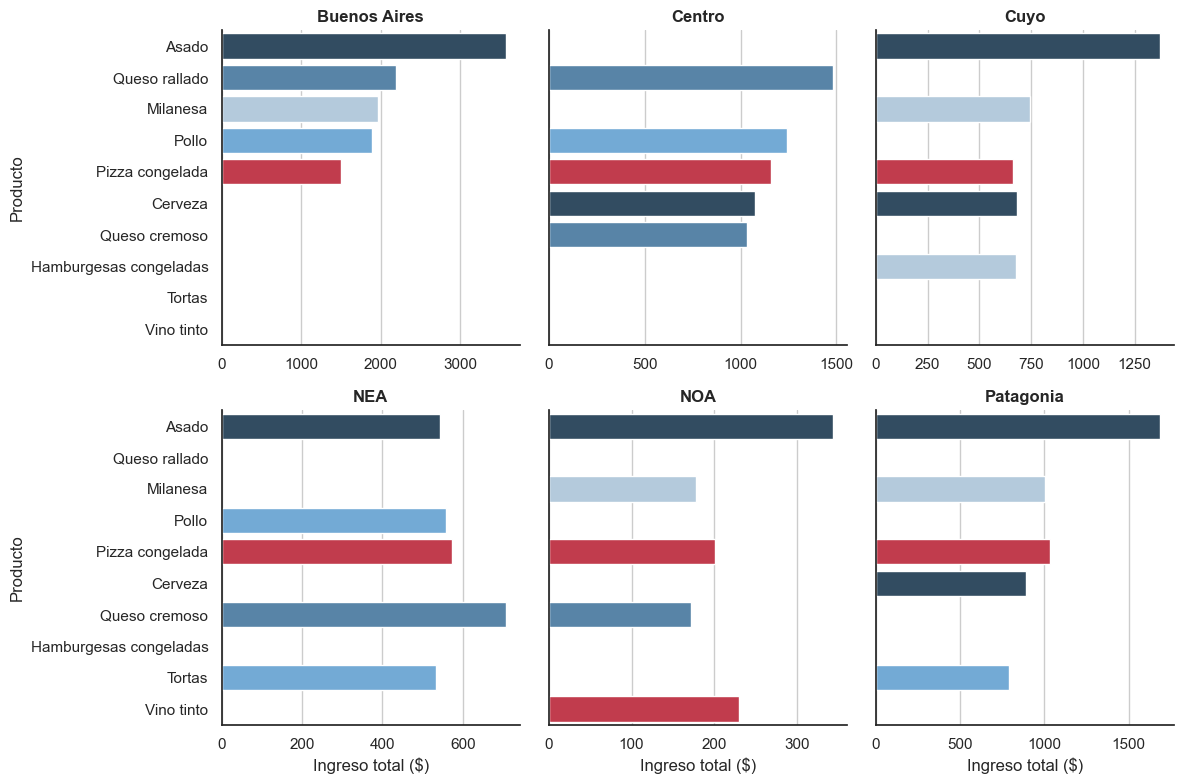

In [37]:
# Gráfico: Top 5 por región

g = sns.catplot(
    data=top5_region,
    kind="bar",
    x="Ingreso",
    y="Nombre_producto",
    col="Región",
    col_wrap=3,
    sharex=False,
    palette=palette_corp,
    height=4
)

g.set_titles("{col_name}")
g.set_axis_labels("Ingreso total ($)", "Producto")
plt.tight_layout()
plt.show()

Bottom 5 productos menos vendidos por región

In [38]:

bottom5_region = (
    prod_region
    .sort_values(["Región", "Ingreso"], ascending=[True, True])  # ahora ascendente
    .groupby("Región")
    .head(5)
    [["Región", "Nombre_producto", "Categoría", "Ingreso", "Pct_Region"]]
)

bottom5_region

,Región,Nombre_producto,Categoría,Ingreso,Pct_Region
35,Buenos Aires,Lentejas,Conservas,204.75,0.551221
20,Buenos Aires,Zanahorias,Frutas y Verduras,266.50,0.717462
21,Buenos Aires,Cebolla,Frutas y Verduras,290.49,0.782048
14,Buenos Aires,Medialunas,Panadería,298.35,0.803208
30,Buenos Aires,Galletitas de agua,Galletitas y Snacks,324.88,0.874631
73,Centro,Lentejas,Conservas,117.00,0.574555
74,Centro,Garbanzos,Conservas,120.45,0.591497
71,Centro,Maníes,Galletitas y Snacks,141.70,0.695850
57,Centro,Lechugas,Frutas y Verduras,165.75,0.813953
55,Centro,Bananas,Frutas y Verduras,166.75,0.818864


C:\Users\erida\AppData\Local\Temp\ipykernel_32484\704304250.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\erida\AppData\Local\Temp\ipykernel_32484\704304250.py:3: UserWarning: 
The palette list has fewer values (5) than needed (14) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


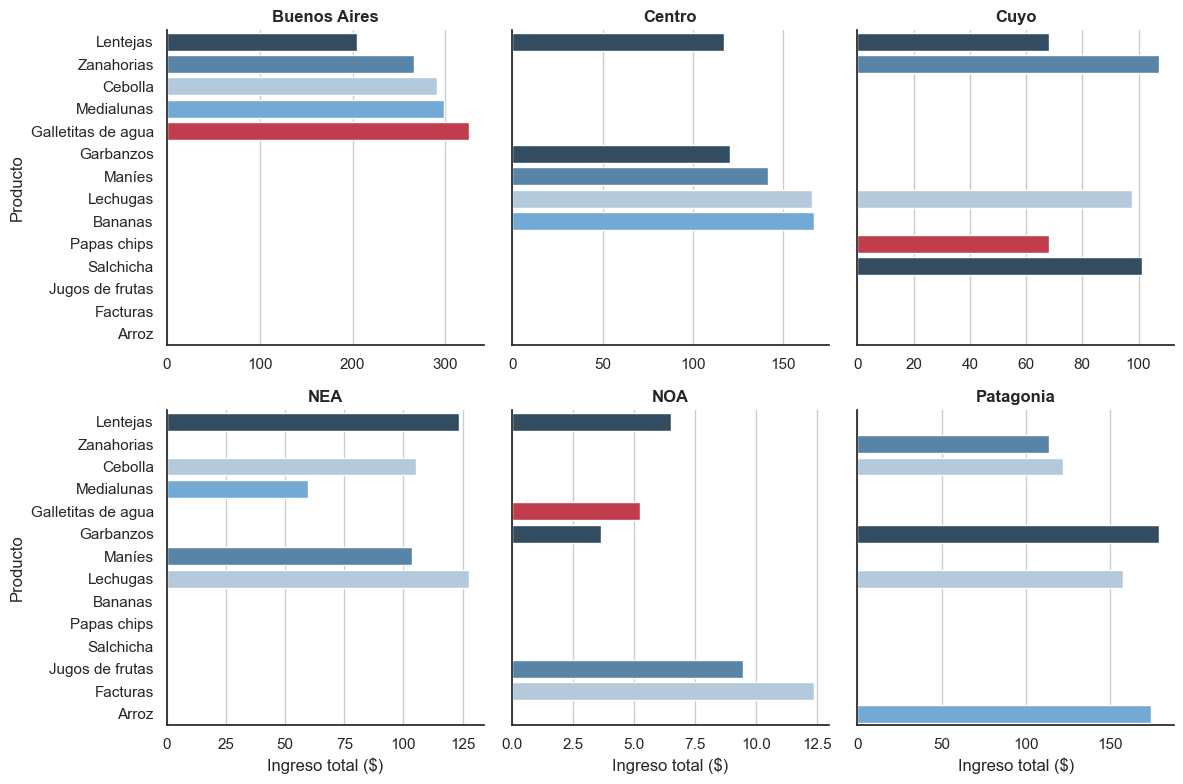

In [39]:
# Gráfico: Bottom 5 por región

g = sns.catplot(
    data=bottom5_region,
    kind="bar",
    x="Ingreso",
    y="Nombre_producto",
    col="Región",
    col_wrap=3,
    sharex=False,
    palette=palette_corp,
    height=4
)

g.set_titles("{col_name}")
g.set_axis_labels("Ingreso total ($)", "Producto")
plt.tight_layout()
plt.show()

Productos que cambian de rol entre regiones

In [40]:

# Volvemos a usar prod_region y definimos una curva tipo ABC por región
prod_region = prod_region.sort_values(["Región", "Ingreso"], ascending=[True, False])

# porcentaje acumulado del ingreso dentro de cada región
prod_region["Pct_Acum"] = (
    prod_region
    .groupby("Región")["Pct_Region"]
    .cumsum()
)

def clasificar_rol(p):
    if p <= 80:
        return "Alto impacto"   
    elif p <= 95:
        return "Impacto medio"  
    else:
        return "Bajo impacto"  

prod_region["Rol_Region"] = prod_region["Pct_Acum"].apply(clasificar_rol)

prod_region

,Región,ID_Producto,Nombre_producto,Categoría,Ingreso,Ingreso_Region,Pct_Region,Pct_Acum,Rol_Region
5,Buenos Aires,6,Asado,Carnicería,3570.00,37144.80,9.611036,9.611036,Alto impacto
3,Buenos Aires,4,Queso rallado,Lácteos,2192.22,37144.80,5.901822,15.512858,Alto impacto
7,Buenos Aires,8,Milanesa,Carnicería,1961.41,37144.80,5.280443,20.793301,Alto impacto
8,Buenos Aires,9,Pollo,Carnicería,1893.12,37144.80,5.096595,25.889896,Alto impacto
24,Buenos Aires,25,Pizza congelada,Congelados,1498.65,37144.80,4.034616,29.924512,Alto impacto
...,...,...,...,...,...,...,...,...,...
222,Patagonia,37,Garbanzos,Conservas,178.85,18553.53,0.963968,96.942145,Bajo impacto
220,Patagonia,35,Arroz,Conservas,174.25,18553.53,0.939174,97.881320,Bajo impacto
205,Patagonia,20,Lechugas,Frutas y Verduras,157.25,18553.53,0.847548,98.728867,Bajo impacto
207,Patagonia,22,Cebolla,Frutas y Verduras,122.09,18553.53,0.658042,99.386909,Bajo impacto


In [41]:
# Matriz producto y región con su rol (alto/medio/bajo)

rol_matrix = (
    prod_region
    .pivot(index="ID_Producto", columns="Región", values="Rol_Region")
    .reset_index()
)

# Añadimos nombre y categoría del producto
rol_matrix = rol_matrix.merge(
    productos[["ID_Producto", "Nombre_producto", "Categoría"]],
    on="ID_Producto",
    how="left"
)

# Reordenar columnas para que quede legible
cols_regiones = [c for c in rol_matrix.columns if c not in ["ID_Producto", "Nombre_producto", "Categoría"]]
rol_matrix = rol_matrix[["ID_Producto", "Nombre_producto", "Categoría"] + cols_regiones]

rol_matrix.head()

,ID_Producto,Nombre_producto,Categoría,Buenos Aires,Centro,Cuyo,NEA,NOA,Patagonia
0,1,Leche,Lácteos,Alto impacto,Alto impacto,Alto impacto,Alto impacto,Alto impacto,Alto impacto
1,2,Yogur,Lácteos,Impacto medio,Impacto medio,Impacto medio,Impacto medio,Impacto medio,Impacto medio
2,3,Queso cremoso,Lácteos,Alto impacto,Alto impacto,Alto impacto,Alto impacto,Alto impacto,Alto impacto
3,4,Queso rallado,Lácteos,Alto impacto,Alto impacto,Alto impacto,Alto impacto,Impacto medio,Alto impacto
4,5,Manteca,Lácteos,Bajo impacto,Impacto medio,Impacto medio,Impacto medio,Impacto medio,Alto impacto


In [42]:
# Detectar productos que cambian de rol entre regiones

# Mapear los roles a un número para poder medir cuánto cambian
map_rol = {"Alto impacto": 1, "Impacto medio": 2, "Bajo impacto": 3}

tmp = prod_region.copy()
tmp["rank_rol"] = tmp["Rol_Region"].map(map_rol)

cambios_rol = (
    tmp
    .groupby("ID_Producto")
    .agg(
        Rol_min=("rank_rol", "min"),
        Rol_max=("rank_rol", "max")
    )
    .reset_index()
)

cambios_rol["Salto_rol"] = cambios_rol["Rol_max"] - cambios_rol["Rol_min"]

# Nos quedamos solo con productos que sí cambian de rol entre regiones
cambios_rol = cambios_rol[cambios_rol["Salto_rol"] > 0].copy()

# Añadimos nombre, categoría y la matriz de roles por región
cambios_rol = cambios_rol.merge(
    rol_matrix,
    on="ID_Producto",
    how="left"
)

# Ordenamos para ver primero los que más cambian
cambios_rol = cambios_rol.sort_values(["Salto_rol", "Nombre_producto"], ascending=[False, True])

# Mostramos los 10 casos más interesantes
cambios_rol.head(10)

,ID_Producto,Rol_min,Rol_max,Salto_rol,Nombre_producto,Categoría,Buenos Aires,Centro,Cuyo,NEA,NOA,Patagonia
10,18,1,3,2,Bananas,Frutas y Verduras,Impacto medio,Bajo impacto,Alto impacto,Impacto medio,Impacto medio,Impacto medio
7,14,1,3,2,Facturas,Panadería,Alto impacto,Impacto medio,Alto impacto,Alto impacto,Bajo impacto,Alto impacto
20,31,1,3,2,Galletitas de agua,Galletitas y Snacks,Bajo impacto,Alto impacto,Bajo impacto,Impacto medio,Bajo impacto,Alto impacto
17,28,1,3,2,Jugos de frutas,Bebidas,Impacto medio,Impacto medio,Alto impacto,Alto impacto,Bajo impacto,Alto impacto
1,5,1,3,2,Manteca,Lácteos,Bajo impacto,Impacto medio,Impacto medio,Impacto medio,Impacto medio,Alto impacto
22,33,1,3,2,Papas chips,Galletitas y Snacks,Alto impacto,Alto impacto,Bajo impacto,Impacto medio,Bajo impacto,Impacto medio
4,11,1,3,2,Salchicha,Carnicería,Alto impacto,Alto impacto,Bajo impacto,Alto impacto,NaN,Alto impacto
16,27,1,2,1,Agua mineral,Bebidas,Alto impacto,Impacto medio,Alto impacto,Alto impacto,Alto impacto,Impacto medio
24,35,2,3,1,Arroz,Conservas,Impacto medio,Impacto medio,Impacto medio,Impacto medio,Bajo impacto,Bajo impacto
26,38,1,2,1,Atún enlatado,Conservas,Impacto medio,Alto impacto,Alto impacto,Alto impacto,Impacto medio,Impacto medio


Categoría y Región por alto.medio / bajo impacto)

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\1886959342.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mat_num = cat_rol_matrix.replace(map_rol_num)


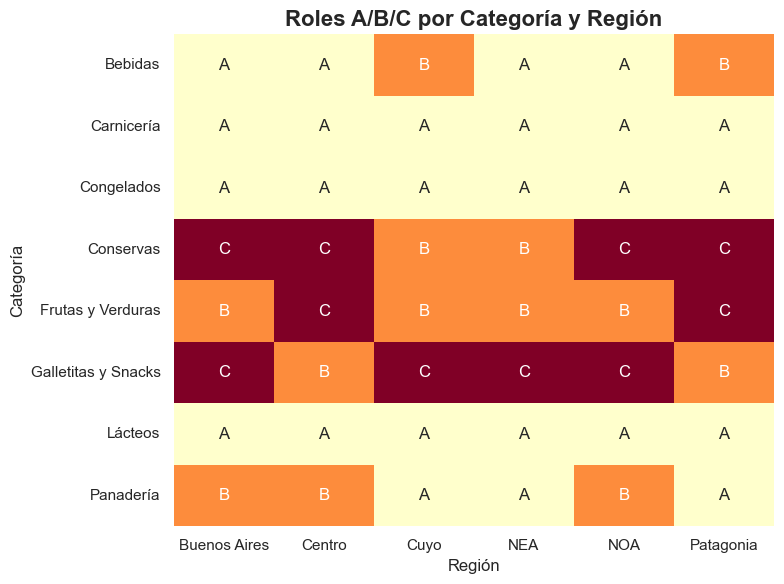

In [43]:
# === Rol por Categoría y Región (alto / medio / bajo impacto) ===

# 1) Ingreso total de cada categoría dentro de cada región
cat_region = (
    ventas_full
    .groupby(["Región", "Categoría"], as_index=False)["Ingreso"]
    .sum()
)

# 2) Calcular % del ingreso dentro de cada región
cat_region["Pct"] = (
    cat_region
    .groupby("Región")["Ingreso"]
    .transform(lambda x: 100 * x / x.sum())
)

# 3) Asignar rol A/B/C según corte 80–95–100%
cat_region = cat_region.sort_values(["Región", "Pct"], ascending=[True, False])
cat_region["Pct_Acum"] = cat_region.groupby("Región")["Pct"].cumsum()

def clasificar(p):
    if p <= 80:
        return "A"
    elif p <= 95:
        return "B"
    else:
        return "C"

cat_region["Rol"] = cat_region["Pct_Acum"].apply(clasificar)

# 4) Matriz de rol categoría vs región
cat_rol_matrix = (
    cat_region
    .pivot(index="Categoría", columns="Región", values="Rol")
)

# 5) Para el heatmap compacto
map_rol_num = {"A": 1, "B": 2, "C": 3}

mat_num = cat_rol_matrix.replace(map_rol_num)
mat_annot = cat_rol_matrix.copy()

# === HEATMAP ===
plt.figure(figsize=(8,6))
sns.heatmap(
    mat_num,
    annot=mat_annot,
    fmt="s",
    cmap="YlOrRd",
    cbar=False
)
plt.title("Roles A/B/C por Categoría y Región")
plt.xlabel("Región")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

Productos que cambian de rol entre regiones

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\842474768.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(map_rol_num)


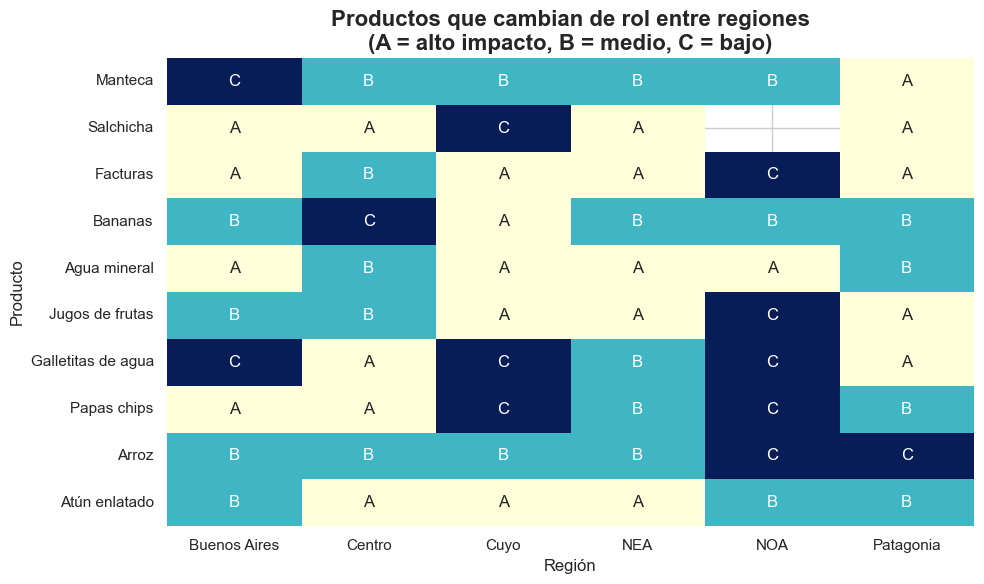

In [44]:

# Productos que cambian de rol
top_cambios = (
    cambios_rol
    .sort_values("Salto_rol", ascending=False)
    .head(10)        
)

ids_top = top_cambios["ID_Producto"].unique()

heat_df = rol_matrix[rol_matrix["ID_Producto"].isin(ids_top)].copy()

# Matriz producto y región
reg_cols = [c for c in heat_df.columns 
            if c not in ["ID_Producto", "Nombre_producto", "Categoría"]]

map_rol_num = {"Alto impacto": 1, "Impacto medio": 2, "Bajo impacto": 3}
map_rol_short = {"Alto impacto": "A", "Impacto medio": "B", "Bajo impacto": "C"}

mat_num = (
    heat_df
    .set_index("Nombre_producto")[reg_cols]
    .replace(map_rol_num)
)

mat_annot = (
    heat_df
    .set_index("Nombre_producto")[reg_cols]
    .replace(map_rol_short)
)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    mat_num,
    annot=mat_annot,
    fmt="s",
    cmap="YlGnBu",
    cbar=False
)
plt.title("Productos que cambian de rol entre regiones\n(A = alto impacto, B = medio, C = bajo)")
plt.xlabel("Región")
plt.ylabel("Producto")
plt.tight_layout()
plt.show()


**Bloque 4 - Métodos de pago** 

In [45]:
mp_global = (
    ventas_full
    .groupby("Método", as_index=False)
    .agg(
        Ingreso_Total=("Ingreso", "sum"),
        Tickets=("Ingreso", "size")  
    )
)

mp_global["Pct_Ingreso"] = 100 * mp_global["Ingreso_Total"] / mp_global["Ingreso_Total"].sum()
mp_global["Pct_Tickets"] = 100 * mp_global["Tickets"] / mp_global["Tickets"].sum()

mp_global = mp_global.sort_values("Ingreso_Total", ascending=False)

mp_global

,Método,Ingreso_Total,Tickets,Pct_Ingreso,Pct_Tickets
1,Mercado Pago,30605.29,872,29.443066,28.788379
4,Transferencia,27758.23,796,26.704122,26.279300
0,Efectivo,18337.48,557,17.641121,18.388907
3,Tarjeta de Débito,18175.58,542,17.485370,17.893694
2,Tarjeta de Crédito,9070.78,262,8.726321,8.649719


C:\Users\erida\AppData\Local\Temp\ipykernel_32484\2151743196.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


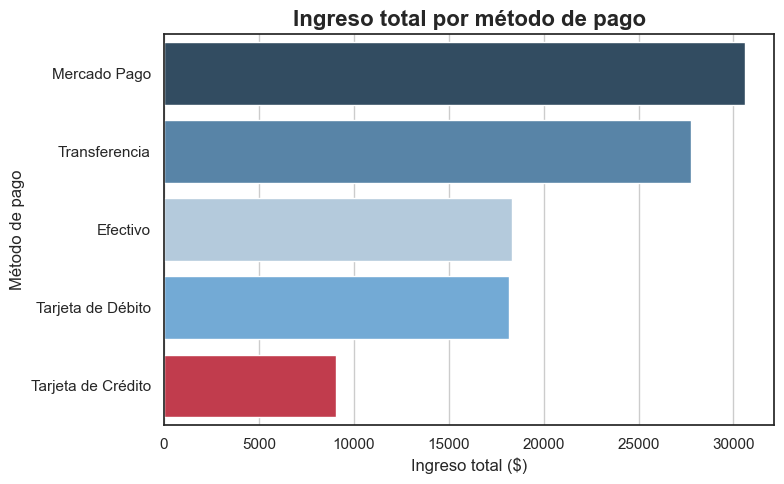

In [46]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=mp_global,
    x="Ingreso_Total",
    y="Método",
    palette=palette_corp
)
plt.title("Ingreso total por método de pago")
plt.xlabel("Ingreso total ($)")
plt.ylabel("Método de pago")
plt.tight_layout()
plt.show()

Métodos de pago por región en terminos de porcentaje

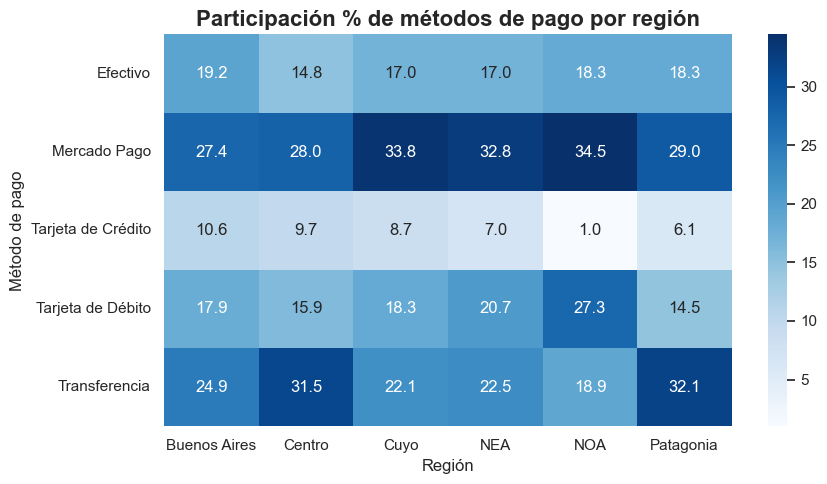

In [47]:
mp_region = (
    ventas_full
    .groupby(["Región", "Método"], as_index=False)
    .agg(Ingreso_Total=("Ingreso", "sum"))
)

mp_region["Pct_Region"] = (
    mp_region
    .groupby("Región")["Ingreso_Total"]
    .transform(lambda x: 100 * x / x.sum())
)

mp_region_pivot = (
    mp_region
    .pivot(index="Método", columns="Región", values="Pct_Region")
    .fillna(0)
)

plt.figure(figsize=(9,5))
sns.heatmap(
    mp_region_pivot,
    annot=True, fmt=".1f",
    cmap="Blues"
)
plt.title("Participación % de métodos de pago por región")
plt.xlabel("Región")
plt.ylabel("Método de pago")
plt.tight_layout()
plt.show()



Categoría y método de pago dentro de cada región

In [48]:
mp_region_cat = (
    ventas_full
    .groupby(["Región", "Categoría", "Método"], as_index=False)
    .agg(Ingreso_Total=("Ingreso", "sum"))
)

mp_region_cat

,Región,Categoría,Método,Ingreso_Total
0,Buenos Aires,Bebidas,Efectivo,672.90
1,Buenos Aires,Bebidas,Mercado Pago,1307.35
2,Buenos Aires,Bebidas,Tarjeta de Crédito,465.16
3,Buenos Aires,Bebidas,Tarjeta de Débito,752.74
4,Buenos Aires,Bebidas,Transferencia,895.57
...,...,...,...,...
220,Patagonia,Panadería,Efectivo,413.90
221,Patagonia,Panadería,Mercado Pago,714.07
222,Patagonia,Panadería,Tarjeta de Crédito,143.32
223,Patagonia,Panadería,Tarjeta de Débito,705.39


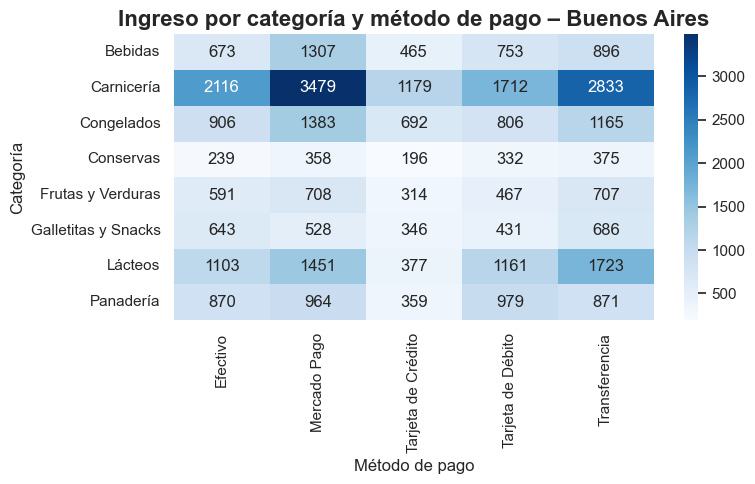

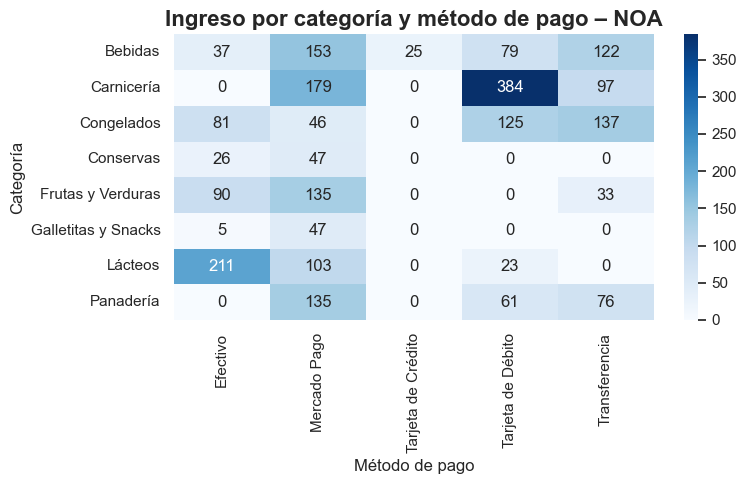

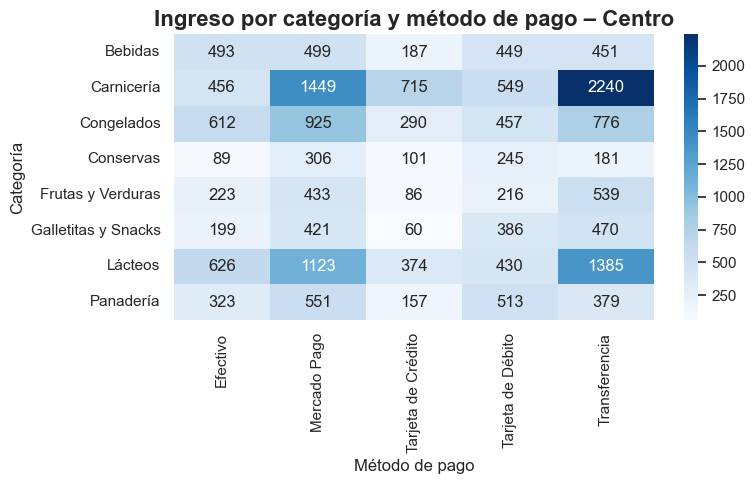

In [49]:
def heatmap_metodos_region(region):
    tmp = mp_region_cat[mp_region_cat["Región"] == region]
    pivot = (
        tmp
        .pivot(index="Categoría", columns="Método", values="Ingreso_Total")
        .fillna(0)
    )
    
    plt.figure(figsize=(8,5))
    sns.heatmap(
        pivot,
        annot=True, fmt=".0f",
        cmap="Blues"
    )
    plt.title(f"Ingreso por categoría y método de pago – {region}")
    plt.xlabel("Método de pago")
    plt.ylabel("Categoría")
    plt.tight_layout()
    plt.show()

# Ejemplos contrastantes
heatmap_metodos_region("Buenos Aires")
heatmap_metodos_region("NOA")
heatmap_metodos_region("Centro")

Métodos de pago en los productos Top 5 por región

In [50]:
# 4.3 – Métodos de pago en los productos Top 5 por región

top5_region_mp = (
    ventas_full
    .groupby(["Región", "ID_Producto", "Nombre_producto", "Categoría"], as_index=False)
    .agg(Ingreso_Total=("Ingreso", "sum"))
    .sort_values(["Región", "Ingreso_Total"], ascending=[True, False])
)

top5_region_mp = top5_region_mp.groupby("Región").head(5)

top5_region_mp



,Región,ID_Producto,Nombre_producto,Categoría,Ingreso_Total
5,Buenos Aires,6,Asado,Carnicería,3570.00
3,Buenos Aires,4,Queso rallado,Lácteos,2192.22
7,Buenos Aires,8,Milanesa,Carnicería,1961.41
8,Buenos Aires,9,Pollo,Carnicería,1893.12
24,Buenos Aires,25,Pizza congelada,Congelados,1498.65
41,Centro,4,Queso rallado,Lácteos,1480.71
46,Centro,9,Pollo,Carnicería,1243.52
62,Centro,25,Pizza congelada,Congelados,1158.75
66,Centro,29,Cerveza,Bebidas,1073.22
40,Centro,3,Queso cremoso,Lácteos,1033.80


In [51]:
# Ventas solo a esos productos estrella
ventas_top5 = ventas_full.merge(
    top5_region_mp[["Región", "ID_Producto"]],
    on=["Región", "ID_Producto"],
    how="inner"
)

mp_top5 = (
    ventas_top5
    .groupby(["Región", "Nombre_producto", "Método"], as_index=False)
    .agg(Ingreso_Total=("Ingreso", "sum"))
)

mp_top5

,Región,Nombre_producto,Método,Ingreso_Total
0,Buenos Aires,Asado,Efectivo,742.56
1,Buenos Aires,Asado,Mercado Pago,1056.72
2,Buenos Aires,Asado,Tarjeta de Crédito,571.20
3,Buenos Aires,Asado,Tarjeta de Débito,456.96
4,Buenos Aires,Asado,Transferencia,742.56
...,...,...,...,...
127,Patagonia,Tortas,Efectivo,30.46
128,Patagonia,Tortas,Mercado Pago,228.45
129,Patagonia,Tortas,Tarjeta de Crédito,45.69
130,Patagonia,Tortas,Tarjeta de Débito,274.14


Gráfica por región

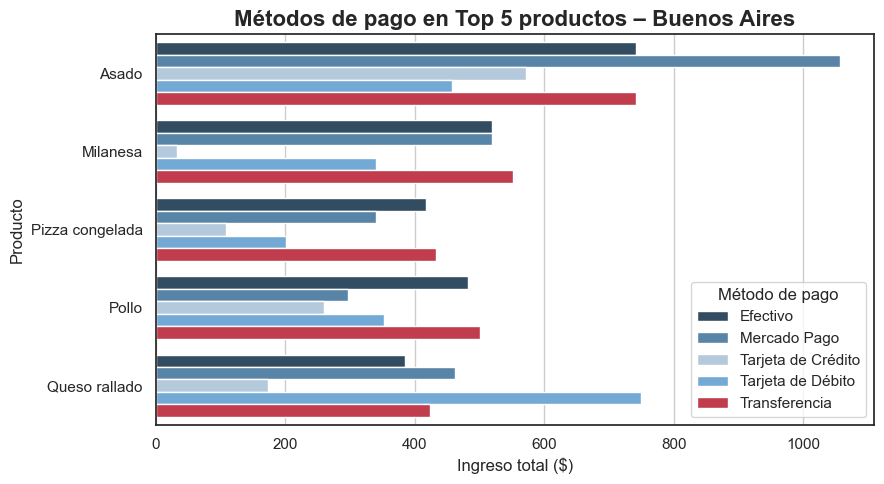

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3113228990.py:5: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(


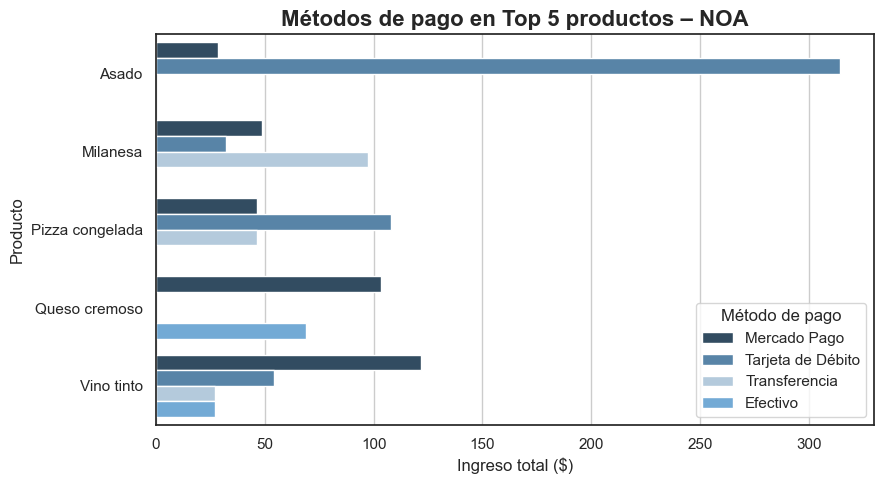

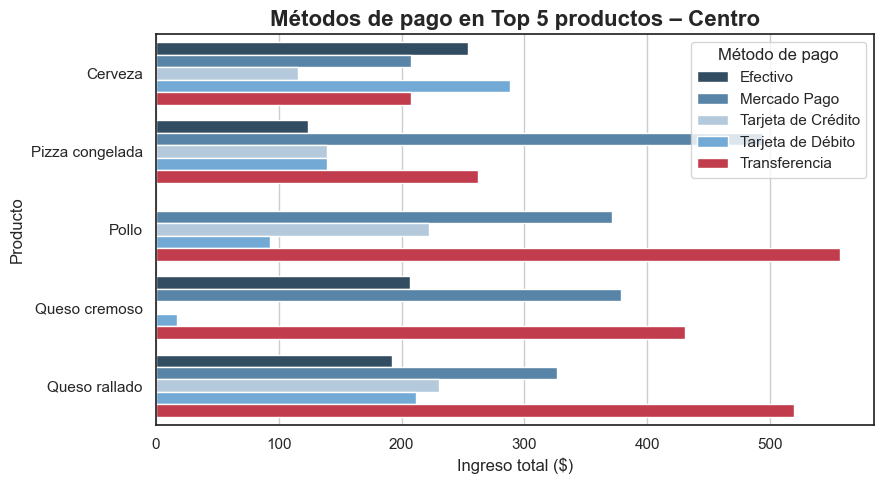

In [52]:
def plot_metodos_top5(region_plot):
    tmp = mp_top5[mp_top5["Región"] == region_plot]
    
    plt.figure(figsize=(9,5))
    sns.barplot(
        data=tmp,
        x="Ingreso_Total",
        y="Nombre_producto",
        hue="Método",
        palette=palette_corp
    )
    plt.title(f"Métodos de pago en Top 5 productos – {region_plot}")
    plt.xlabel("Ingreso total ($)")
    plt.ylabel("Producto")
    plt.legend(title="Método de pago")
    plt.tight_layout()
    plt.show()

# Ejemplos:
plot_metodos_top5("Buenos Aires")
plot_metodos_top5("NOA")
plot_metodos_top5("Centro")

**Bloque 5 - Métricas de cliente por región**

In [53]:
ventas_full

,ID_Venta,Fecha_Ventas,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre_producto,Categoría,Precio_Unitario,...,Fecha_Registro,Región,Método,Descripción_y,Año,Mes,Dia,Dia_Semana,Ingreso,Mes_Label
0,919,2024-01-31,10,25,5,1,Completa,Pizza congelada,Congelados,15.45,...,2023-11-23,Buenos Aires,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,77.25,Ene
1,947,2024-01-31,106,5,1,4,Completa,Manteca,Lácteos,5.65,...,2023-06-23,NEA,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,5.65,Ene
2,1317,2024-01-31,235,25,3,3,Completa,Pizza congelada,Congelados,15.45,...,2023-12-11,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,31,Mié,46.35,Ene
3,1607,2024-01-31,114,15,5,1,Completa,Medialunas,Panadería,3.51,...,2023-04-11,Centro,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,31,Mié,17.55,Ene
4,2038,2024-01-31,132,2,5,4,Completa,Yogur,Lácteos,5.21,...,2023-12-14,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,31,Mié,26.05,Ene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,2024-12-30,44,12,6,4,Completa,Pan francés,Panadería,8.12,...,2023-09-17,Buenos Aires,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,12,30,Lun,48.72,Dic
3025,1390,2024-12-30,26,31,3,4,Completa,Galletitas de agua,Galletitas y Snacks,5.24,...,2023-07-05,Centro,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,12,30,Lun,15.72,Dic
3026,1519,2024-12-30,246,11,3,3,Completa,Salchicha,Carnicería,11.23,...,2023-09-28,NEA,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,12,30,Lun,33.69,Dic
3027,2147,2024-12-30,231,22,2,1,Pendiente,Cebolla,Frutas y Verduras,4.21,...,2023-12-13,Patagonia,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,12,30,Lun,8.42,Dic


In [54]:
# Perfil de cliente por región

# Ventas agregadas por cliente y región
cliente_region = (
    ventas_full
    .groupby(["Región", "ID_Cliente"], as_index=False)
    .agg(
        Tickets=("Ingreso", "size"),          # cuántas compras hizo ese cliente
        Ingreso_Cliente=("Ingreso", "sum")    # cuánto gastó en total
    )
)

# Resumen agregado por región
perfil_region = (
    cliente_region
    .groupby("Región", as_index=False)
    .agg(
        Clientes_Unicos=("ID_Cliente", "nunique"),
        Tickets_Promedio=("Tickets", "mean"),
        Ingreso_Promedio_Cliente=("Ingreso_Cliente", "mean"),
        Ingreso_Mediano_Cliente=("Ingreso_Cliente", "median")
    )
)

perfil_region

,Región,Clientes_Unicos,Tickets_Promedio,Ingreso_Promedio_Cliente,Ingreso_Mediano_Cliente
0,Buenos Aires,111,9.378378,334.637838,314.990
1,Centro,63,9.666667,323.231429,315.070
2,Cuyo,44,9.181818,322.215682,313.125
3,NEA,37,9.594595,304.089730,271.490
4,NOA,7,9.000000,350.948571,325.110
5,Patagonia,64,8.703125,289.898906,287.315


Segmentación de frecuencia de clientes por región

In [55]:
# Segmentación: ocasional / frecuente / recurrente

def clasificar_frecuencia(n):
    if n <= 5:
        return "Frecuente (1–5 compras)"
    else:
        return "Recurrente (6+ compras)"

cliente_region["Segmento_Frecuencia"] = cliente_region["Tickets"].apply(clasificar_frecuencia)

freq_region = (
    cliente_region
    .groupby(["Región", "Segmento_Frecuencia"], as_index=False)
    .agg(Clientes=("ID_Cliente", "nunique"))
)

# Porcentaje dentro de cada región
freq_region["Pct_Clientes"] = (
    freq_region
    .groupby("Región")["Clientes"]
    .transform(lambda x: 100 * x / x.sum())
)

freq_region


,Región,Segmento_Frecuencia,Clientes,Pct_Clientes
0,Buenos Aires,Frecuente (1–5 compras),11,9.909910
1,Buenos Aires,Recurrente (6+ compras),100,90.090090
2,Centro,Frecuente (1–5 compras),4,6.349206
3,Centro,Recurrente (6+ compras),59,93.650794
4,Cuyo,Frecuente (1–5 compras),4,9.090909
5,Cuyo,Recurrente (6+ compras),40,90.909091
6,NEA,Frecuente (1–5 compras),2,5.405405
7,NEA,Recurrente (6+ compras),35,94.594595
8,NOA,Recurrente (6+ compras),7,100.000000
9,Patagonia,Frecuente (1–5 compras),8,12.500000


Gráfico apilado del tipo de clientes por región

<Figure size 900x500 with 0 Axes>

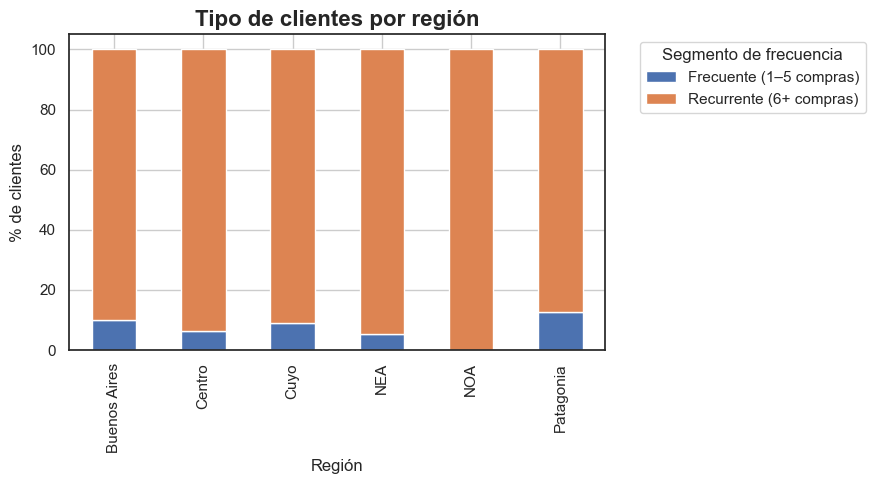

In [56]:
plt.figure(figsize=(9,5))

freq_pivot = (
    freq_region
    .pivot(index="Región", columns="Segmento_Frecuencia", values="Pct_Clientes")
    .fillna(0)
)

freq_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(9,5)
)

plt.ylabel("% de clientes")
plt.title("Tipo de clientes por región")
plt.legend(title="Segmento de frecuencia", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


**Bloque 6 - Clustering de productos**

Agrupamos los productos según cómo se comportan en el negocio:

Cuánto venden (ingreso total).

En qué regiones son fuertes.

Qué tanto dependen de Buenos Aires.

Si viven más entre semana o en fin de semana.

Qué tan “repartida” está su venta entre regiones.

Todo eso lo condensamos en una tabla con una fila por producto. 
Después, esa tabla es la que se escala y entra al K-Means.

Construir dataset a nivel producto


In [57]:
# Métricas básicas por producto
prod_base = (
    ventas_full
    .groupby(["ID_Producto", "Nombre_producto", "Categoría"], as_index=False)
    .agg(
        Ingreso_Total=("Ingreso", "sum"),
        Tickets_Prod=("ID_Venta", "nunique"),
        Cantidad_Total=("Cantidad", "sum")
    )
)

# Ingreso por producto y región
prod_reg = (
    ventas_full
    .groupby(["ID_Producto", "Región"], as_index=False)["Ingreso"]
    .sum()
)

# % del ingreso del producto que viene de cada región
prod_reg["Ingreso_Total_Prod"] = prod_reg.groupby("ID_Producto")["Ingreso"].transform("sum")
prod_reg["Pct_Region_Prod"] = prod_reg["Ingreso"] / prod_reg["Ingreso_Total_Prod"]

# Porcentaje del producto que viene de Buenos Aires
pct_ba = (
    prod_reg[prod_reg["Región"] == "Buenos Aires"]
    .loc[:, ["ID_Producto", "Pct_Region_Prod"]]
    .rename(columns={"Pct_Region_Prod": "Pct_BA"})
)

# Número de regiones donde el producto realmente vende algo
n_regiones_activas = (
    prod_reg[prod_reg["Ingreso"] > 0]
    .groupby("ID_Producto", as_index=False)["Región"]
    .nunique()
    .rename(columns={"Región": "N_Regiones_Activas"})
)

# Porcentaje de ingreso del producto que viene del fin de semana
prod_finde = (
    ventas_full
    .assign(
        Es_Finde=lambda df: df["Dia_Semana"].isin(["Sáb", "Dom"]).astype(int)
    )
    .groupby(["ID_Producto", "Es_Finde"], as_index=False)["Ingreso"]
    .sum()
)

prod_finde["Ingreso_Total_Prod"] = prod_finde.groupby("ID_Producto")["Ingreso"].transform("sum")
prod_finde["Pct_Finde"] = prod_finde["Ingreso"] / prod_finde["Ingreso_Total_Prod"]

pct_finde = (
    prod_finde[prod_finde["Es_Finde"] == 1]
    .loc[:, ["ID_Producto", "Pct_Finde"]]
)

# Unimos todo en un solo dataset de productos
df_productos_modelo = (
    prod_base
    .merge(pct_ba, on="ID_Producto", how="left")
    .merge(n_regiones_activas, on="ID_Producto", how="left")
    .merge(pct_finde, on="ID_Producto", how="left")
)

# Si algún producto nunca se vendió en finde, Pct_Finde queda en 0
df_productos_modelo["Pct_Finde"] = df_productos_modelo["Pct_Finde"].fillna(0)

df_productos_modelo.head()

,ID_Producto,Nombre_producto,Categoría,Ingreso_Total,Tickets_Prod,Cantidad_Total,Pct_BA,N_Regiones_Activas,Pct_Finde
0,1,Leche,Lácteos,3378.24,81,276,0.434783,6,0.278986
1,2,Yogur,Lácteos,1422.33,82,273,0.271062,6,0.249084
2,3,Queso cremoso,Lácteos,4703.79,84,273,0.300366,6,0.227106
3,4,Queso rallado,Lácteos,4980.57,77,259,0.440154,6,0.347490
4,5,Manteca,Lácteos,1695.00,80,300,0.210000,6,0.303333


Estamos construyendo la ficha básica de cada producto:

Ingreso_Total → cuánto dinero genera ese producto en todo el año.

Tickets_Prod → en cuántos tickets aparece (qué tan frecuente se vende).

Cantidad_Total → cuántas unidades se vendieron en total.

Ticket_Promedio_Prod → cuánto aporta, en promedio, cada vez que aparece en un ticket.

Escalado y elección de k

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Variables numéricas para el clustering
vars_cluster = ["Ingreso_Total", "Ticket_Promedio_Prod", "Pct_BA", "N_Regiones_Activas", "Pct_Finde"]

# Primero calculamos el ticket promedio por producto
df_productos_modelo["Ticket_Promedio_Prod"] = (
    df_productos_modelo["Ingreso_Total"] / df_productos_modelo["Tickets_Prod"]
)

X = df_productos_modelo[["Ingreso_Total", "Ticket_Promedio_Prod", "Pct_BA", "N_Regiones_Activas", "Pct_Finde"]].copy()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Búsqueda rápida de k 
resultados_k = []
for k in [2, 3, 4, 5, 6]:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    inercia = kmeans_temp.inertia_
    sil = silhouette_score(X_scaled, labels_temp)
    resultados_k.append([k, inercia, sil])

resultados_k



[[2, 136.4310676875656, np.float64(0.24232037687165078)],
 [3, 100.75274924105494, np.float64(0.29292360999313694)],
 [4, 81.04568597030936, np.float64(0.2571612416235423)],
 [5, 65.37927536906754, np.float64(0.276401420692725)],
 [6, 53.667511729206936, np.float64(0.2875970517322678)]]

Esto mide dónde realmente vive cada producto. Hay productos que prácticamente existen solo si Buenos Aires compra y otros que se venden en todo el país. Ese peso regional es clave para entender riesgos y oportunidades.

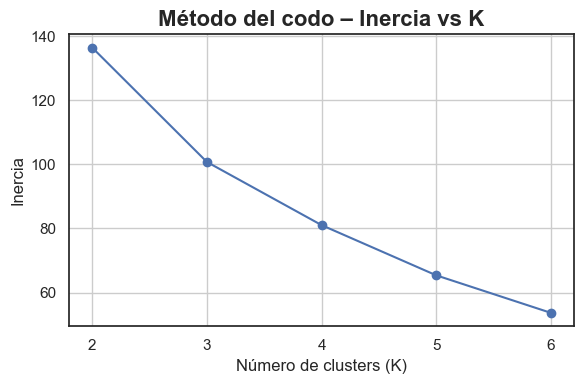

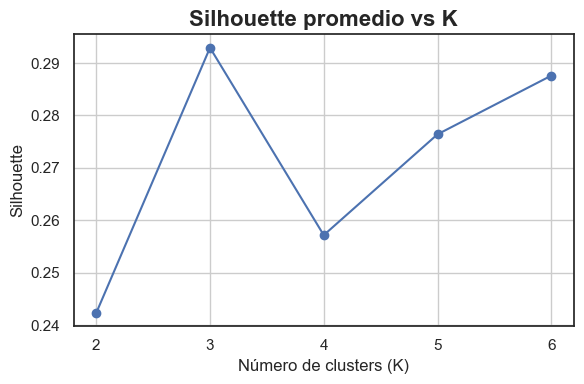

In [59]:
# Pasamos resultados a DataFrame para graficar codo
res_k_df = pd.DataFrame(resultados_k, columns=["K", "Inercia", "Silhouette"])

# ---- Gráfico de codo (Inercia vs K) ----
plt.figure(figsize=(6,4))
plt.plot(res_k_df["K"], res_k_df["Inercia"], marker="o")
plt.xticks(res_k_df["K"])
plt.title("Método del codo – Inercia vs K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.tight_layout()
plt.show()

# ---- Gráfico de Silhouette vs K ----
plt.figure(figsize=(6,4))
plt.plot(res_k_df["K"], res_k_df["Silhouette"], marker="o")
plt.xticks(res_k_df["K"])
plt.title("Silhouette promedio vs K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

Entrenar K-means final con k = 3

In [60]:
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_productos_modelo["Cluster"] = kmeans.fit_predict(X_scaled)

df_productos_modelo[[
    "ID_Producto", "Nombre_producto", "Categoría",
    "Ingreso_Total", "Ticket_Promedio_Prod",
    "Pct_BA", "N_Regiones_Activas", "Pct_Finde",
    "Cluster"
]].head()


,ID_Producto,Nombre_producto,Categoría,Ingreso_Total,Ticket_Promedio_Prod,Pct_BA,N_Regiones_Activas,Pct_Finde,Cluster
0,1,Leche,Lácteos,3378.24,41.706667,0.434783,6,0.278986,0
1,2,Yogur,Lácteos,1422.33,17.345488,0.271062,6,0.249084,1
2,3,Queso cremoso,Lácteos,4703.79,55.997500,0.300366,6,0.227106,0
3,4,Queso rallado,Lácteos,4980.57,64.682727,0.440154,6,0.347490,0
4,5,Manteca,Lácteos,1695.00,21.187500,0.210000,6,0.303333,1


Resumen tabular por clúster 

In [61]:
resumen_clusters = (
    df_productos_modelo
    .groupby("Cluster", as_index=False)
    .agg(
        Productos=("ID_Producto", "nunique"),
        Ingreso_Promedio=("Ingreso_Total", "mean"),
        Ticket_Promedio_Prod=("Ticket_Promedio_Prod", "mean"),
        Pct_BA_Promedio=("Pct_BA", "mean"),
        Regiones_Activas_Prom=("N_Regiones_Activas", "mean"),
        Pct_Finde_Prom=("Pct_Finde", "mean")
    )
)

resumen_clusters

,Cluster,Productos,Ingreso_Promedio,Ticket_Promedio_Prod,Pct_BA_Promedio,Regiones_Activas_Prom,Pct_Finde_Prom
0,0,15,4336.026667,54.425456,0.360379,6.0,0.294401
1,1,19,1694.126316,21.686418,0.334063,6.0,0.291170
2,2,4,1679.640000,21.328744,0.367769,5.0,0.308477


Elegir variables y escalarlas. En donde:

La idea es que el modelo vea cosas tipo:

Qué tanto vende (tamaño del producto).

Qué tanto depende de Buenos Aires.

En cuántas regiones vive.

Qué tanto es de fin de semana.

Resumen de categorías dentro de cada clúster

In [62]:
# Distribución de categorías por clúster
dist_cat_cluster = (
    df_productos_modelo
    .groupby(["Cluster", "Categoría"], as_index=False)["ID_Producto"]
    .nunique()
    .rename(columns={"ID_Producto": "Productos"})
)

# Pasar a % dentro de cada clúster
dist_cat_cluster["Pct_Cluster"] = (
    dist_cat_cluster
    .groupby("Cluster")["Productos"]
    .transform(lambda x: 100 * x / x.sum())
)

dist_cat_cluster.sort_values(["Cluster", "Pct_Cluster"], ascending=[True, False])




,Cluster,Categoría,Productos,Pct_Cluster
1,0,Carnicería,5,33.333333
2,0,Congelados,3,20.000000
3,0,Lácteos,3,20.000000
0,0,Bebidas,2,13.333333
4,0,Panadería,2,13.333333
8,1,Frutas y Verduras,5,26.315789
7,1,Conservas,4,21.052632
9,1,Galletitas y Snacks,3,15.789474
5,1,Bebidas,2,10.526316
10,1,Lácteos,2,10.526316


Visualización PCA 2D

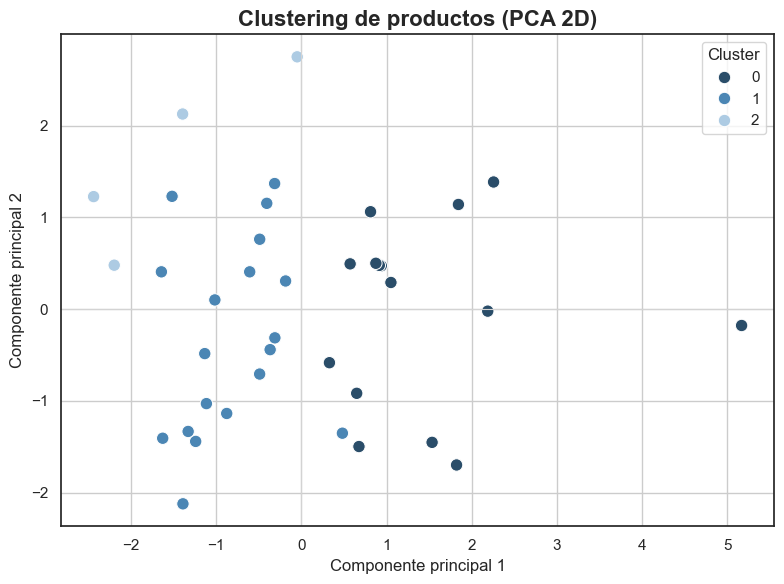

In [63]:
from sklearn.decomposition import PCA

# Reducimos a 2 componentes para visualizar
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(X_scaled)

df_pca = df_productos_modelo.copy()
df_pca["PC1"] = coords_2d[:, 0]
df_pca["PC2"] = coords_2d[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Cluster",
    palette=palette_corp[:k_final],
    s=80
)
plt.title("Clustering de productos (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.axhline(0, color="lightgray", linewidth=0.8)
plt.axvline(0, color="lightgray", linewidth=0.8)
plt.tight_layout()
plt.show()



Ejemplos concretos por clúster


In [64]:
ejemplos_cluster = (
    df_productos_modelo
    .sort_values(["Cluster", "Ingreso_Total"], ascending=[True, False])
    .groupby("Cluster")
    .head(3)  # top 3 productos por clúster
    [["Cluster", "Nombre_producto", "Categoría", "Ingreso_Total", "Ticket_Promedio_Prod"]]
)

ejemplos_cluster


,Cluster,Nombre_producto,Categoría,Ingreso_Total,Ticket_Promedio_Prod
5,0,Asado,Carnicería,8539.44,105.425185
7,0,Milanesa,Carnicería,5187.20,58.283146
24,0,Pizza congelada,Congelados,5129.40,59.644186
13,1,Facturas,Panadería,2682.12,38.316000
22,1,Papas fritas,Congelados,2510.15,27.284239
11,1,Pan francés,Panadería,2436.00,29.707317
10,2,Salchicha,Carnicería,2852.42,39.074247
31,2,Galletitas de chocolate,Galletitas y Snacks,2075.00,22.802198
14,2,Medialunas,Panadería,926.64,12.355200


**Bloque 7 – Dataset precio–cantidad por categoría** 

In [65]:
# Dataset a nivel producto (precio promedio y volumen total)
df_price = (
    ventas_full
    .groupby(["Categoría", "ID_Producto", "Nombre_producto"], as_index=False)
    .agg(
        Precio_Unitario=("Precio_Unitario", "mean"),
        Cantidad=("Cantidad", "sum"),
        Ingreso=("Ingreso", "sum")
    )
)

df_price.head()



,Categoría,ID_Producto,Nombre_producto,Precio_Unitario,Cantidad,Ingreso
0,Bebidas,27,Agua mineral,6.21,358,2223.18
1,Bebidas,28,Jugos de frutas,9.45,228,2154.60
2,Bebidas,29,Cerveza,11.54,353,4073.62
3,Bebidas,30,Vino tinto,13.54,243,3290.22
4,Carnicería,6,Asado,28.56,299,8539.44


Elasticidad por categoría

In [66]:
import statsmodels.api as sm

# Función para interpretar elasticidad
def interpretar_elasticidad(e):
    if pd.isna(e):
        return "No estimable (sin variación de precio)"
    if e < -1:
        return "Muy elástico – bajar precio suele aumentar ingreso"
    if -1 <= e < -0.5:
        return "Elástico – sensible al precio"
    if -0.5 <= e < 0:
        return "Inelástico – subir precio suele aumentar ingreso"
    return "Anómalo (revisar datos)"

elasticidades_cat = {}

for cat in df_price["Categoría"].unique():
    df_sub = df_price[df_price["Categoría"] == cat].copy()

    # Necesitamos que dentro de la categoría haya productos con distinto precio
    if df_sub["Precio_Unitario"].nunique() > 1:
        df_sub["ln_Q"] = np.log(df_sub["Cantidad"] + 1)
        df_sub["ln_P"] = np.log(df_sub["Precio_Unitario"] + 1)

        X = sm.add_constant(df_sub["ln_P"])
        y = df_sub["ln_Q"]

        try:
            model = sm.OLS(y, X).fit()
            elasticidades_cat[cat] = model.params["ln_P"]
        except:
            elasticidades_cat[cat] = np.nan
    else:
        elasticidades_cat[cat] = np.nan

elasticidad_df = pd.DataFrame({
    "Categoría": list(elasticidades_cat.keys()),
    "Elasticidad": list(elasticidades_cat.values())
})

elasticidad_df["Clasificación"] = elasticidad_df["Elasticidad"].apply(interpretar_elasticidad)

elasticidad_df


,Categoría,Elasticidad,Clasificación
0,Bebidas,-0.363703,Inelástico – subir precio suele aumentar ingreso
1,Carnicería,0.090193,Anómalo (revisar datos)
2,Congelados,-0.123476,Inelástico – subir precio suele aumentar ingreso
3,Conservas,0.673444,Anómalo (revisar datos)
4,Frutas y Verduras,-0.002339,Inelástico – subir precio suele aumentar ingreso
5,Galletitas y Snacks,-0.562028,Elástico – sensible al precio
6,Lácteos,-0.064665,Inelástico – subir precio suele aumentar ingreso
7,Panadería,-0.126193,Inelástico – subir precio suele aumentar ingreso


Gráfica: Elasticidad por categoría

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\1300563658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


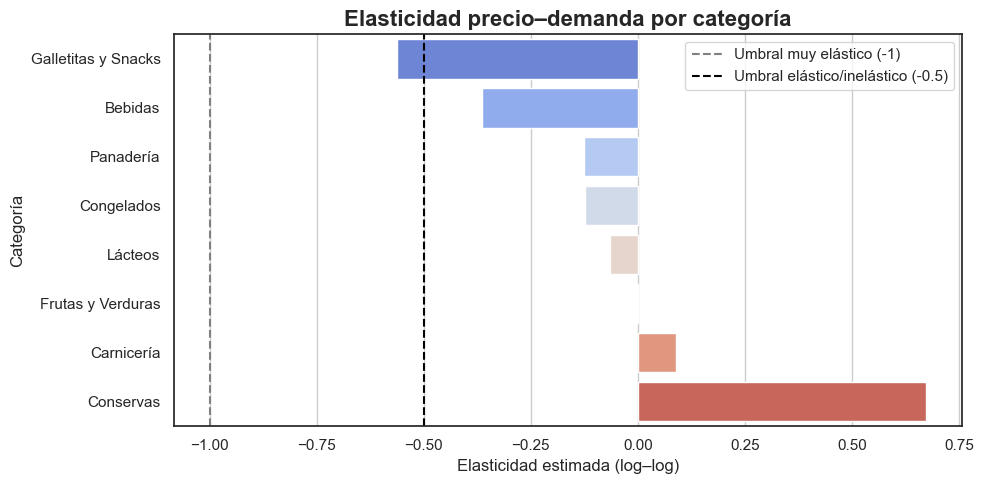

In [67]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=elasticidad_df.sort_values("Elasticidad"),
    x="Elasticidad",
    y="Categoría",
    palette="coolwarm"
)
plt.axvline(-1, linestyle="--", color="gray", label="Umbral muy elástico (-1)")
plt.axvline(-0.5, linestyle="--", color="black", label="Umbral elástico/inelástico (-0.5)")
plt.title("Elasticidad precio–demanda por categoría")
plt.xlabel("Elasticidad estimada (log–log)")
plt.ylabel("Categoría")
plt.legend()
plt.tight_layout()
plt.show()

Categorías más inelásticas --> Se puede subir el precio y aumentará el ingreso, sin riesgo inmediato a perder demanda.

1) Galletitas y Snacks
2) Bebidas
3) Panadería 

Categorías más elásticas --> Son sensibles a los cambios de precio: si se sube, existe el riesgo inmediato de perder demanda.

1) Conservas
2) Carnicería

Preparar base "Región y Categoría" para simulación

In [68]:
df_cat_reg = (
    ventas_full
    .groupby(["Región", "Categoría"], as_index=False)
    .agg(
        Ingreso_Actual=("Ingreso", "sum"),
        Cantidad=("Cantidad", "sum"),
        Precio_Promedio=("Precio_Unitario", "mean")
    )
)

# Unimos la elasticidad por categoría
df_cat_reg = df_cat_reg.merge(
    elasticidad_df[["Categoría", "Elasticidad"]],
    on="Categoría",
    how="left"
)

df_cat_reg

,Región,Categoría,Ingreso_Actual,Cantidad,Precio_Promedio,Elasticidad
0,Buenos Aires,Bebidas,4093.72,413,9.839590,-0.363703
1,Buenos Aires,Carnicería,11319.11,672,16.718167,0.090193
2,Buenos Aires,Congelados,4953.21,432,11.312727,-0.123476
3,Buenos Aires,Conservas,1499.34,342,4.320612,0.673444
4,Buenos Aires,Frutas y Verduras,2786.90,515,5.429333,-0.002339
5,Buenos Aires,Galletitas y Snacks,2634.36,413,6.493793,-0.562028
6,Buenos Aires,Lácteos,5815.37,453,12.744638,-0.064665
7,Buenos Aires,Panadería,4042.79,401,9.936379,-0.126193
8,Centro,Bebidas,2079.87,198,10.626721,-0.363703
9,Centro,Carnicería,5409.28,339,16.195761,0.090193


Definir escenarios de precio

In [69]:
# Tomamos la clasificación ya calculada
cat_inelasticas = elasticidad_df[
    elasticidad_df["Clasificación"].str.contains("Inelástico", na=False)
]["Categoría"].tolist()

cat_muy_elasticas = elasticidad_df[
    elasticidad_df["Clasificación"].str.contains("Muy elástico", na=False)
]["Categoría"].tolist()

escenarios = {
    "Escenario 1: +10% todas las categorías": {
        "tipo": "global",
        "pct": 0.10
    },
    "Escenario 2: +10% solo categorías inelásticas": {
        "tipo": "selectivo",
        "pct": 0.10,
        "categorias_objetivo": cat_inelasticas
    },
    "Escenario 3: -10% categorías muy elásticas": {
        "tipo": "selectivo",
        "pct": -0.10,
        "categorias_objetivo": cat_muy_elasticas
    }
}

escenarios

{'Escenario 1: +10% todas las categorías': {'tipo': 'global', 'pct': 0.1},
 'Escenario 2: +10% solo categorías inelásticas': {'tipo': 'selectivo',
  'pct': 0.1,
  'categorias_objetivo': ['Bebidas',
   'Congelados',
   'Frutas y Verduras',
   'Lácteos',
   'Panadería']},
 'Escenario 3: -10% categorías muy elásticas': {'tipo': 'selectivo',
  'pct': -0.1,
  'categorias_objetivo': []}}

Función de simulación

In [70]:
def simular_ingreso_categoria(row, pct_cambio):
    """
    row: fila con Precio_Promedio, Cantidad, Elasticidad
    pct_cambio: +0.10 para +10%, -0.10 para -10%
    """
    e = row["Elasticidad"]
    
    # Si no tenemos elasticidad, asumimos que la categoría es neutra
    if pd.isna(e):
        return row["Ingreso_Actual"]
    
    precio_nuevo = row["Precio_Promedio"] * (1 + pct_cambio)
    cantidad_nueva = row["Cantidad"] * (1 + e * pct_cambio)
    
    # Evitar cantidades negativas por si la elasticidad es muy grande en valor absoluto
    cantidad_nueva = max(cantidad_nueva, 0)
    
    return precio_nuevo * cantidad_nueva


Simulación de escenarios por región

In [71]:
resultados_escenarios = []

for nombre_esc, config in escenarios.items():
    tipo = config["tipo"]
    pct = config["pct"]
    cats_obj = config.get("categorias_objetivo", [])

    df_tmp = df_cat_reg.copy()
    
    if tipo == "global":
        # Aplicamos el cambio a todas las categorías
        df_tmp["Ingreso_Sim"] = df_tmp.apply(
            lambda r: simular_ingreso_categoria(r, pct),
            axis=1
        )
    else:
        # Solo categorías objetivo; el resto se deja igual
        def sim_selectivo(r):
            if r["Categoría"] in cats_obj:
                return simular_ingreso_categoria(r, pct)
            else:
                return r["Ingreso_Actual"]
        
        df_tmp["Ingreso_Sim"] = df_tmp.apply(sim_selectivo, axis=1)
    
    # Agregamos a nivel región
    resumen_reg = (
        df_tmp
        .groupby("Región", as_index=False)
        .agg(
            Ingreso_Actual=("Ingreso_Actual", "sum"),
            Ingreso_Sim=("Ingreso_Sim", "sum")
        )
    )
    resumen_reg["Escenario"] = nombre_esc
    resumen_reg["Delta_Abs"] = resumen_reg["Ingreso_Sim"] - resumen_reg["Ingreso_Actual"]
    resumen_reg["Delta_Pct"] = 100 * resumen_reg["Delta_Abs"] / resumen_reg["Ingreso_Actual"]
    
    resultados_escenarios.append(resumen_reg)

impacto_regional = pd.concat(resultados_escenarios, ignore_index=True)
impacto_regional


,Región,Ingreso_Actual,Ingreso_Sim,Escenario,Delta_Abs,Delta_Pct
0,Buenos Aires,37144.80,40317.919043,Escenario 1: +10% todas las categorías,3173.119043,8.542566
1,Centro,20363.58,22498.752857,Escenario 1: +10% todas las categorías,2135.172857,10.485253
2,Cuyo,14177.49,15547.956704,Escenario 1: +10% todas las categorías,1370.466704,9.666497
3,NEA,11251.32,12470.953158,Escenario 1: +10% todas las categorías,1219.633158,10.839912
4,NOA,2456.64,2714.277683,Escenario 1: +10% todas las categorías,257.637683,10.487401
5,Patagonia,18553.53,20499.877334,Escenario 1: +10% todas las categorías,1946.347334,10.490442
6,Buenos Aires,37144.80,38781.997142,Escenario 2: +10% solo categorías inelásticas,1637.197142,4.407608
7,Centro,20363.58,21626.028941,Escenario 2: +10% solo categorías inelásticas,1262.448941,6.199543
8,Cuyo,14177.49,15070.495545,Escenario 2: +10% solo categorías inelásticas,893.005545,6.298756
9,NEA,11251.32,11975.736276,Escenario 2: +10% solo categorías inelásticas,724.416276,6.438500


Gráfica: Ingreso base vs escenario, por región

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\640853.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(


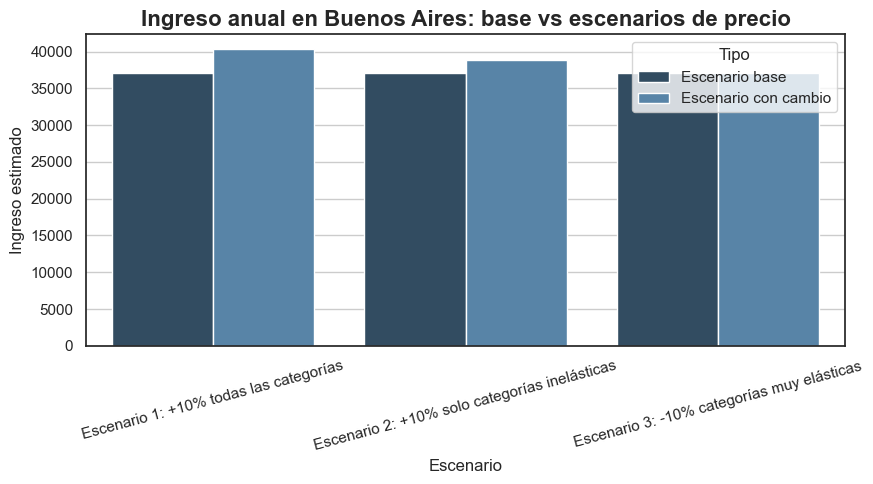

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\640853.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(


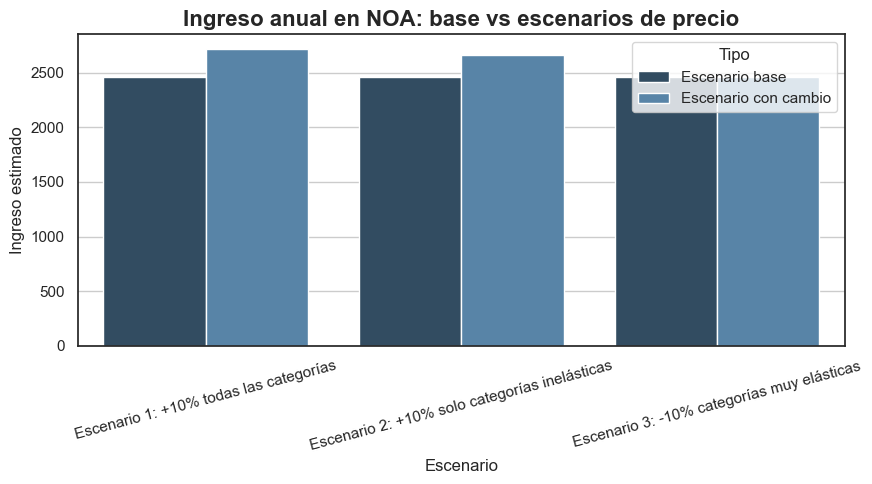

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\640853.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(


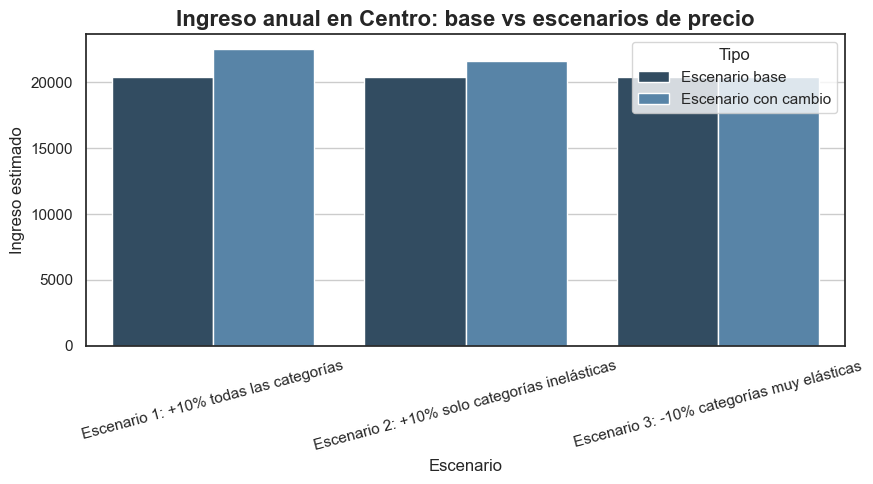

In [72]:
def plot_escenarios_region(region_focus):
    tmp = impacto_regional[impacto_regional["Región"] == region_focus].copy()

    tmp_long = tmp.melt(
        id_vars=["Región", "Escenario"],
        value_vars=["Ingreso_Actual", "Ingreso_Sim"],
        var_name="Tipo",
        value_name="Ingreso"
    )

    tmp_long["Tipo"] = tmp_long["Tipo"].map({
        "Ingreso_Actual": "Escenario base",
        "Ingreso_Sim": "Escenario con cambio"
    })

    plt.figure(figsize=(9,5))
    sns.barplot(
        data=tmp_long,
        x="Escenario",
        y="Ingreso",
        hue="Tipo",
        palette=palette_corp
    )
    plt.title(f"Ingreso anual en {region_focus}: base vs escenarios de precio")
    plt.xlabel("Escenario")
    plt.ylabel("Ingreso estimado")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Ejemplo:
plot_escenarios_region("Buenos Aires")

plot_escenarios_region("NOA")

plot_escenarios_region("Centro")


In [73]:
# Ver resumen promedio de cambios por escenario
resumen_esc = (
    impacto_regional
    .groupby("Escenario", as_index=False)
    .agg(
        Cambio_Promedio_Pct=("Delta_Pct", "mean"),
        Cambio_Min_Pct=("Delta_Pct", "min"),
        Cambio_Max_Pct=("Delta_Pct", "max")
    )
)

print(resumen_esc)

# Y ver también por región y escenario
impacto_regional[["Región", "Escenario", "Ingreso_Actual", "Ingreso_Sim", "Delta_Pct"]]

                                       Escenario  Cambio_Promedio_Pct  \
0         Escenario 1: +10% todas las categorías            10.085345   
1  Escenario 2: +10% solo categorías inelásticas             6.229783   
2     Escenario 3: -10% categorías muy elásticas             0.000000   

   Cambio_Min_Pct  Cambio_Max_Pct  
0        8.542566       10.839912  
1        4.407608        8.181559  
2        0.000000        0.000000  


,Región,Escenario,Ingreso_Actual,Ingreso_Sim,Delta_Pct
0,Buenos Aires,Escenario 1: +10% todas las categorías,37144.80,40317.919043,8.542566
1,Centro,Escenario 1: +10% todas las categorías,20363.58,22498.752857,10.485253
2,Cuyo,Escenario 1: +10% todas las categorías,14177.49,15547.956704,9.666497
3,NEA,Escenario 1: +10% todas las categorías,11251.32,12470.953158,10.839912
4,NOA,Escenario 1: +10% todas las categorías,2456.64,2714.277683,10.487401
5,Patagonia,Escenario 1: +10% todas las categorías,18553.53,20499.877334,10.490442
6,Buenos Aires,Escenario 2: +10% solo categorías inelásticas,37144.80,38781.997142,4.407608
7,Centro,Escenario 2: +10% solo categorías inelásticas,20363.58,21626.028941,6.199543
8,Cuyo,Escenario 2: +10% solo categorías inelásticas,14177.49,15070.495545,6.298756
9,NEA,Escenario 2: +10% solo categorías inelásticas,11251.32,11975.736276,6.438500


Porcentaje de cambio por región y escenario:

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\2339850356.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(  # Asignamos el barplot a una variable 'ax' para más control


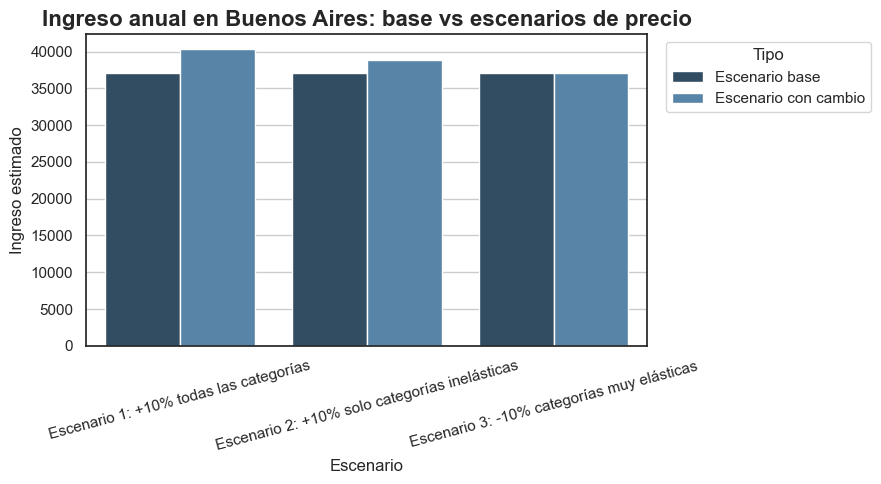

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\2339850356.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(  # Asignamos el barplot a una variable 'ax' para más control


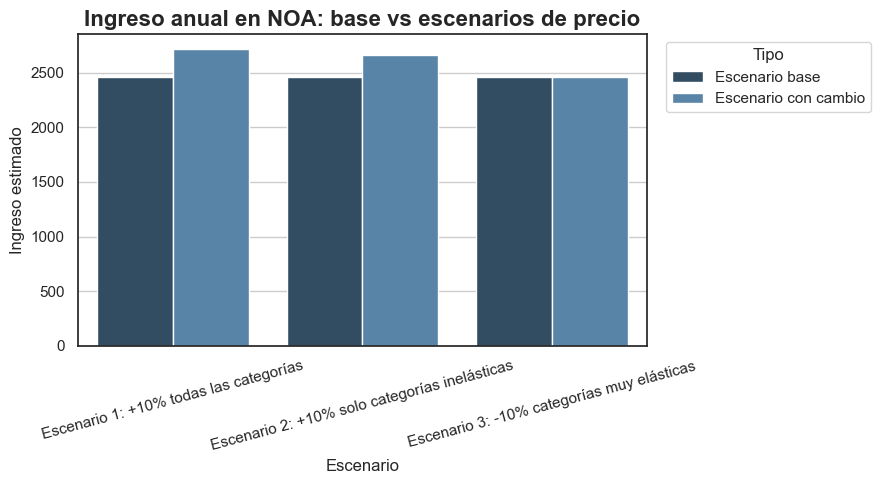

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\2339850356.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(  # Asignamos el barplot a una variable 'ax' para más control


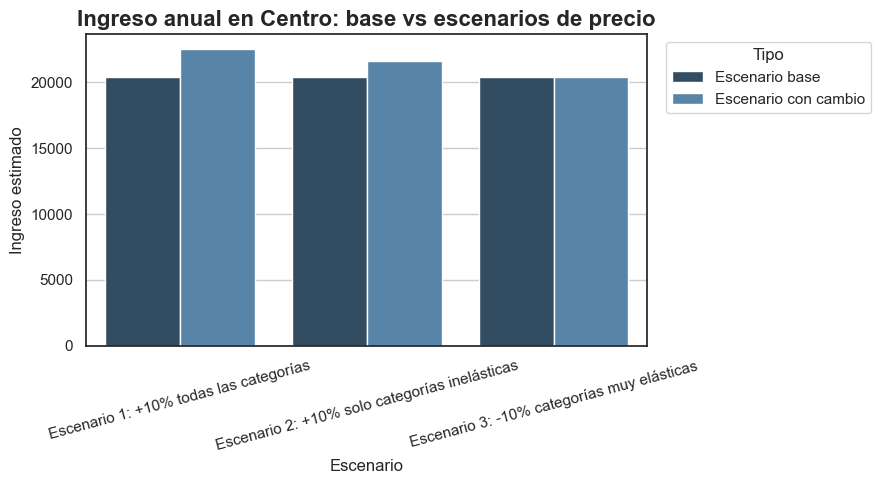

In [74]:
def plot_escenarios_region(region_focus):
    tmp = impacto_regional[impacto_regional["Región"] == region_focus].copy()

    tmp_long = tmp.melt(
        id_vars=["Región", "Escenario"],
        value_vars=["Ingreso_Actual", "Ingreso_Sim"],
        var_name="Tipo",
        value_name="Ingreso"
    )

    tmp_long["Tipo"] = tmp_long["Tipo"].map({
        "Ingreso_Actual": "Escenario base",
        "Ingreso_Sim": "Escenario con cambio"
    })

    plt.figure(figsize=(9,5))
    ax = sns.barplot(  # Asignamos el barplot a una variable 'ax' para más control
        data=tmp_long,
        x="Escenario",
        y="Ingreso",
        hue="Tipo",
        palette=palette_corp
    )
    plt.title(f"Ingreso anual en {region_focus}: base vs escenarios de precio")
    plt.xlabel("Escenario")
    plt.ylabel("Ingreso estimado")
    plt.xticks(rotation=15)

    # --- CÓDIGO AÑADIDO/MODIFICADO PARA MOVER LA LEYENDA ---
    # Opción 1: Mover la leyenda fuera del gráfico, a la derecha (recomendado)
    # bbox_to_anchor=(1.05, 1) coloca la leyenda en la esquina superior derecha del área de la figura.
    # loc='upper left' indica dónde anclar la leyenda a ese punto.
    plt.legend(title='Tipo', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Opción 2: Mover la leyenda dentro del gráfico, pero en la esquina superior izquierda
    # plt.legend(title='Tipo', loc='upper left')
    # ------------------------------------------------------------

    plt.tight_layout()
    plt.show()

# Ejemplo:
plot_escenarios_region("Buenos Aires")
plot_escenarios_region("NOA")
plot_escenarios_region("Centro")

C:\Users\erida\AppData\Local\Temp\ipykernel_32484\3544883389.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(


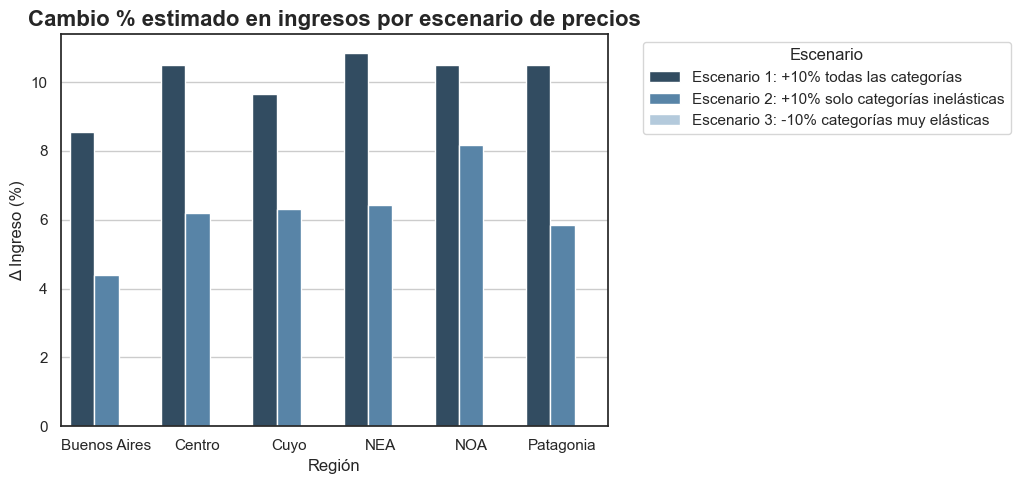

In [75]:
# Tomamos solo columnas principales
tmp = impacto_regional.copy()

plt.figure(figsize=(10.5,5))
sns.barplot(
    data=tmp,
    x="Región",
    y="Delta_Pct",
    hue="Escenario",
    palette=palette_corp
)
plt.title("Cambio % estimado en ingresos por escenario de precios")
plt.xlabel("Región")
plt.ylabel("Δ Ingreso (%)")
plt.legend(title="Escenario", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Generación de archivos para dashboard

In [76]:
# 1) Exportar ventas_full
ventas_full.to_csv("ventas_full.csv", index=False, encoding="utf-8")

# 2) Dimensión de productos (únicos)
dim_productos = (
    productos[["ID_Producto", "Nombre_producto", "Categoría"]]
    .drop_duplicates()
)

dim_productos.to_csv("dim_productos.csv", index=False, encoding="utf-8")

# 3) Si ya tienes la tabla de escenarios de precios
# impacto_regional con columnas: Región, Escenario, Ingreso_Actual, Ingreso_Sim, Delta_Pct
try:
    impacto_regional.to_csv("impacto_regional.csv", index=False, encoding="utf-8")
    print("impacto_regional.csv exportado.")
except NameError:
    print("impacto_regional no existe aún, saltando...")

# 4) Opcional: dimensión clientes
dim_clientes = (
    ventas_full[["ID_Cliente", "Región"]]
    .drop_duplicates()
)

dim_clientes.to_csv("dim_clientes.csv", index=False, encoding="utf-8")

print("Listo: CSV generados en la carpeta de trabajo.")

impacto_regional.csv exportado.
Listo: CSV generados en la carpeta de trabajo.


# Fin del código